In [63]:
import pandas as pd
import yfinance as yf
from tqdm import tqdm


esg_csv = "../data/raw/sp500_esg_ceo_info-filtered.csv"  
esg_df = pd.read_csv(esg_csv)

print("Columnas CSV ESG:", esg_df.columns)
print("Número de tickers en CSV:", esg_df["Ticker"].nunique())

Columnas CSV ESG: Index(['Ticker', 'ESG Score', 'Governance Score', 'Environment Score',
       'Social Score', 'ESG Score Date', 'ESG Status', 'CEO Full Name',
       'CEO Gender', 'CEO Status', 'Year'],
      dtype='object')
Número de tickers en CSV: 426


In [64]:
# Selección de únicamente 50 tickers del CSV sp500_esg_ceo_info-filtered

tickers = esg_df["Ticker"].dropna().unique().tolist()[:50]

start_date = "2018-01-01"
end_date = "2025-08-30"

all_data = []


In [65]:
batch_size = 50
for i in range(0, len(tickers), batch_size):
    batch = tickers[i:i+batch_size]
    print(f"\nDescargando batch {i//batch_size + 1} de {len(tickers)//batch_size + 1}...")
    
    try:
        df = yf.download(
            batch,
            start=start_date,
            end=end_date,
            progress=False,
            auto_adjust=False  # 
        )
        
        # Pasamos de columnas multi-índice a columnas simples
        df = df.stack(level=1).reset_index()
        df.rename(columns={"level_1": "Ticker"}, inplace=True)
        
        all_data.append(df)
    except Exception as e:
        print(f"Error en batch {i//batch_size + 1}: {e}")



Descargando batch 1 de 2...



1 Failed download:
['ANSS']: YFPricesMissingError('possibly delisted; no price data found  (1d 2018-01-01 -> 2025-08-30) (Yahoo error = "No data found, symbol may be delisted")')
/tmp/ipykernel_65730/1142295356.py:16: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = df.stack(level=1).reset_index()


In [66]:
# Unimos todos los datos financieros
fin_df = pd.concat(all_data, ignore_index=True)

print(f"\nDatos financieros: {fin_df.shape}")


Datos financieros: (94374, 8)


In [67]:
# Unimos con ESG (por ticker)
dataset_final = pd.merge(fin_df, esg_df, on="Ticker", how="inner")

In [68]:
# Creamos features de volatilidad para obtener 2 posibles targets (y) para nuestro futuro modelo predictivo

dataset_final["Daily_Return"] = dataset_final.groupby("Ticker")["Adj Close"].pct_change()
dataset_final["Daily_Volatility"] = (
    dataset_final.groupby("Ticker")["Daily_Return"]
    .rolling(5)
    .std()
    .reset_index(0, drop=True)
)

In [69]:
# Guardar CSV final
dataset_final.to_csv("dataset_final.csv", index=False)

print(f"\nDataset guardado como 'dataset_final.csv'")
print("Shape final:", dataset_final.shape)
print("\nPrimeras filas:\n", dataset_final.head())

dataset_final.info()


Dataset guardado como 'dataset_final.csv'
Shape final: (94374, 20)

Primeras filas:
         Date Ticker  Adj Close      Close       High        Low       Open  \
0 2018-01-02      A  63.909576  67.599998  67.889999  67.339996  67.419998   
1 2018-01-02    AAL  51.647564  52.990002  53.099998  51.900002  52.330002   
2 2018-01-02   AAPL  40.380997  43.064999  43.075001  42.314999  42.540001   
3 2018-01-02   ABBV  70.405556  98.410004  98.900002  96.750000  97.139999   
4 2018-01-02    ABT  51.307533  58.790001  59.200001  57.820000  58.200001   

        Volume  ESG Score  Governance Score  Environment Score  Social Score  \
0    1047800.0      15.24              6.26               0.34          8.65   
1    4084700.0      29.10              5.26              11.53         12.31   
2  102223600.0      16.68              9.18               0.65          6.86   
3    4561300.0      27.84              9.95               1.12         16.77   
4   10112800.0      24.98              8.36  

EDA

In [70]:
dataset_final.head()

Date Ticker  Adj Close      Close       High        Low       Open  \
0 2018-01-02      A  63.909576  67.599998  67.889999  67.339996  67.419998   
1 2018-01-02    AAL  51.647564  52.990002  53.099998  51.900002  52.330002   
2 2018-01-02   AAPL  40.380997  43.064999  43.075001  42.314999  42.540001   
3 2018-01-02   ABBV  70.405556  98.410004  98.900002  96.750000  97.139999   
4 2018-01-02    ABT  51.307533  58.790001  59.200001  57.820000  58.200001   

        Volume  ESG Score  Governance Score  Environment Score  Social Score  \
0    1047800.0      15.24              6.26               0.34          8.65   
1    4084700.0      29.10              5.26              11.53         12.31   
2  102223600.0      16.68              9.18               0.65          6.86   
3    4561300.0      27.84              9.95               1.12         16.77   
4   10112800.0      24.98              8.36               3.03         13.59   

  ESG Score Date ESG Status            CEO Full Name CEO Gender CEO Status  \
0     01/01/2023    success  Mr. Michael R. McMullen       male    success   
1     01/01/2023    success   Mr. Robert D. Isom Jr.       male    success   
2     01/08/2022    success      Mr. Timothy D. Cook       male    success   
3     01/08/2022    success  Mr. Richard A. Gonzalez       male    success   
4     01/08/2022    success       Mr. Robert B. Ford       male    success   

   Year  Daily_Return  Daily_Volatility  
0    23           NaN               NaN  
1    23           NaN               NaN  
2    22           NaN               NaN  
3    22           NaN               NaN  
4    22           NaN               NaN

In [71]:
dataset_final.shape

(94374, 20)

In [72]:
dataset_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94374 entries, 0 to 94373
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Date               94374 non-null  datetime64[ns]
 1   Ticker             94374 non-null  object        
 2   Adj Close          94374 non-null  float64       
 3   Close              94374 non-null  float64       
 4   High               94374 non-null  float64       
 5   Low                94374 non-null  float64       
 6   Open               94374 non-null  float64       
 7   Volume             94374 non-null  float64       
 8   ESG Score          94374 non-null  float64       
 9   Governance Score   94374 non-null  float64       
 10  Environment Score  94374 non-null  float64       
 11  Social Score       94374 non-null  float64       
 12  ESG Score Date     94374 non-null  object        
 13  ESG Status         94374 non-null  object        
 14  CEO Fu

In [73]:
dataset_final.drop_duplicates()

Date Ticker   Adj Close       Close        High         Low  \
0     2018-01-02      A   63.909576   67.599998   67.889999   67.339996   
1     2018-01-02    AAL   51.647564   52.990002   53.099998   51.900002   
2     2018-01-02   AAPL   40.380997   43.064999   43.075001   42.314999   
3     2018-01-02   ABBV   70.405556   98.410004   98.900002   96.750000   
4     2018-01-02    ABT   51.307533   58.790001   59.200001   57.820000   
...          ...    ...         ...         ...         ...         ...   
94369 2025-08-29  GOOGL  212.719742  212.910004  214.649994  210.199997   
94370 2025-08-29    LNT   65.070000   65.070000   65.459999   64.750000   
94371 2025-08-29    MMM  155.529999  155.529999  158.240005  155.320007   
94372 2025-08-29     MO   66.141098   67.209999   67.250000   66.459999   
94373 2025-08-29      T   29.290001   29.290001   29.330000   28.950001   

             Open       Volume  ESG Score  Governance Score  \
0       67.419998    1047800.0      15.24              6.26   
1       52.330002    4084700.0      29.10              5.26   
2       42.540001  102223600.0      16.68              9.18   
3       97.139999    4561300.0      27.84              9.95   
4       58.200001   10112800.0      24.98              8.36   
...           ...          ...        ...               ...   
94369  210.509995   39728400.0      24.14             11.39   
94370   65.099998    1669600.0      21.87              6.18   
94371  157.600006    3279100.0      33.61              7.72   
94372   66.550003    5930600.0      23.99              6.35   
94373   29.020000   26562400.0      22.07              6.66   

       Environment Score  Social Score ESG Score Date ESG Status  \
0                   0.34          8.65     01/01/2023    success   
1                  11.53         12.31     01/01/2023    success   
2                   0.65          6.86     01/08/2022    success   
3                   1.12         16.77     01/08/2022    success   
4                   3.03         13.59     01/08/2022    success   
...                  ...           ...            ...        ...   
94369               1.66         11.10     01/08/2022    success   
94370              10.04          5.65     01/01/2023    success   
94371              12.33         13.56     01/08/2022    success   
94372               4.66         12.98     01/08/2022    success   
94373               2.27         13.15     01/08/2022    success   

                    CEO Full Name CEO Gender CEO Status  Year  Daily_Return  \
0         Mr. Michael R. McMullen       male    success    23           NaN   
1          Mr. Robert D. Isom Jr.       male    success    23           NaN   
2             Mr. Timothy D. Cook       male    success    22           NaN   
3         Mr. Richard A. Gonzalez       male    success    22           NaN   
4              Mr. Robert B. Ford       male    success    22           NaN   
...                           ...        ...        ...   ...           ...   
94369          Mr. Sundar  Pichai       male    success    22      0.006001   
94370          Mr. John O. Larsen       male    success    23      0.000769   
94371        Mr. Michael F. Roman       male    success    22     -0.012884   
94372  Mr. William F. Gifford Jr.       male    success    22      0.011894   
94373         Mr. John T. Stankey       male    success    22      0.012094   

       Daily_Volatility  
0                   NaN  
1                   NaN  
2                   NaN  
3                   NaN  
4                   NaN  
...                 ...  
94369          0.010028  
94370          0.006497  
94371          0.009568  
94372          0.008617  
94373          0.010537  

[94374 rows x 20 columns]

In [74]:
dataset_final.dropna(inplace=True)

In [75]:
dataset_final.shape

(94129, 20)

In [76]:
tickers_only = dataset_final[['Ticker']].drop_duplicates()  # eliminamos duplicados de los tickers para obtener los nombres exactos de las empresas elegidas

tickers_only.to_csv("tickers_only.csv", index=False)

In [77]:
dataset_final.drop(["CEO Full Name", "CEO Status"], axis = 1, inplace = True)
dataset_final.head()

Date Ticker  Adj Close       Close        High        Low  \
245 2018-01-09      A  67.851929   71.769997   72.330002  70.169998   
246 2018-01-09    AAL  50.760616   52.080002   53.369999  52.009998   
247 2018-01-09   AAPL  40.866245   43.582500   43.764999  43.352501   
248 2018-01-09   ABBV  71.714798  100.239998  100.660004  98.699997   
249 2018-01-09    ABT  51.420967   58.919998   59.099998  58.380001   

          Open      Volume  ESG Score  Governance Score  Environment Score  \
245  70.680000   2666100.0      15.24              6.26               0.34   
246  52.970001   3426000.0      29.10              5.26              11.53   
247  43.637501  86336000.0      16.68              9.18               0.65   
248  99.489998   4055400.0      27.84              9.95               1.12   
249  59.099998   7466900.0      24.98              8.36               3.03   

     Social Score ESG Score Date ESG Status CEO Gender  Year  Daily_Return  \
245          8.65     01/01/2023    success       male    23      0.024554   
246         12.31     01/01/2023    success       male    23     -0.000959   
247          6.86     01/08/2022    success       male    22     -0.000115   
248         16.77     01/08/2022    success       male    22      0.007539   
249         13.59     01/08/2022    success       male    22      0.001700   

     Daily_Volatility  
245          0.014419  
246          0.007580  
247          0.005833  
248          0.014342  
249          0.002566

In [78]:
dataset_final.info()

<class 'pandas.core.frame.DataFrame'>
Index: 94129 entries, 245 to 94373
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Date               94129 non-null  datetime64[ns]
 1   Ticker             94129 non-null  object        
 2   Adj Close          94129 non-null  float64       
 3   Close              94129 non-null  float64       
 4   High               94129 non-null  float64       
 5   Low                94129 non-null  float64       
 6   Open               94129 non-null  float64       
 7   Volume             94129 non-null  float64       
 8   ESG Score          94129 non-null  float64       
 9   Governance Score   94129 non-null  float64       
 10  Environment Score  94129 non-null  float64       
 11  Social Score       94129 non-null  float64       
 12  ESG Score Date     94129 non-null  object        
 13  ESG Status         94129 non-null  object        
 14  CEO Gende

## ANÁLISIS DE VARIABLES UNIVARIANTE ##

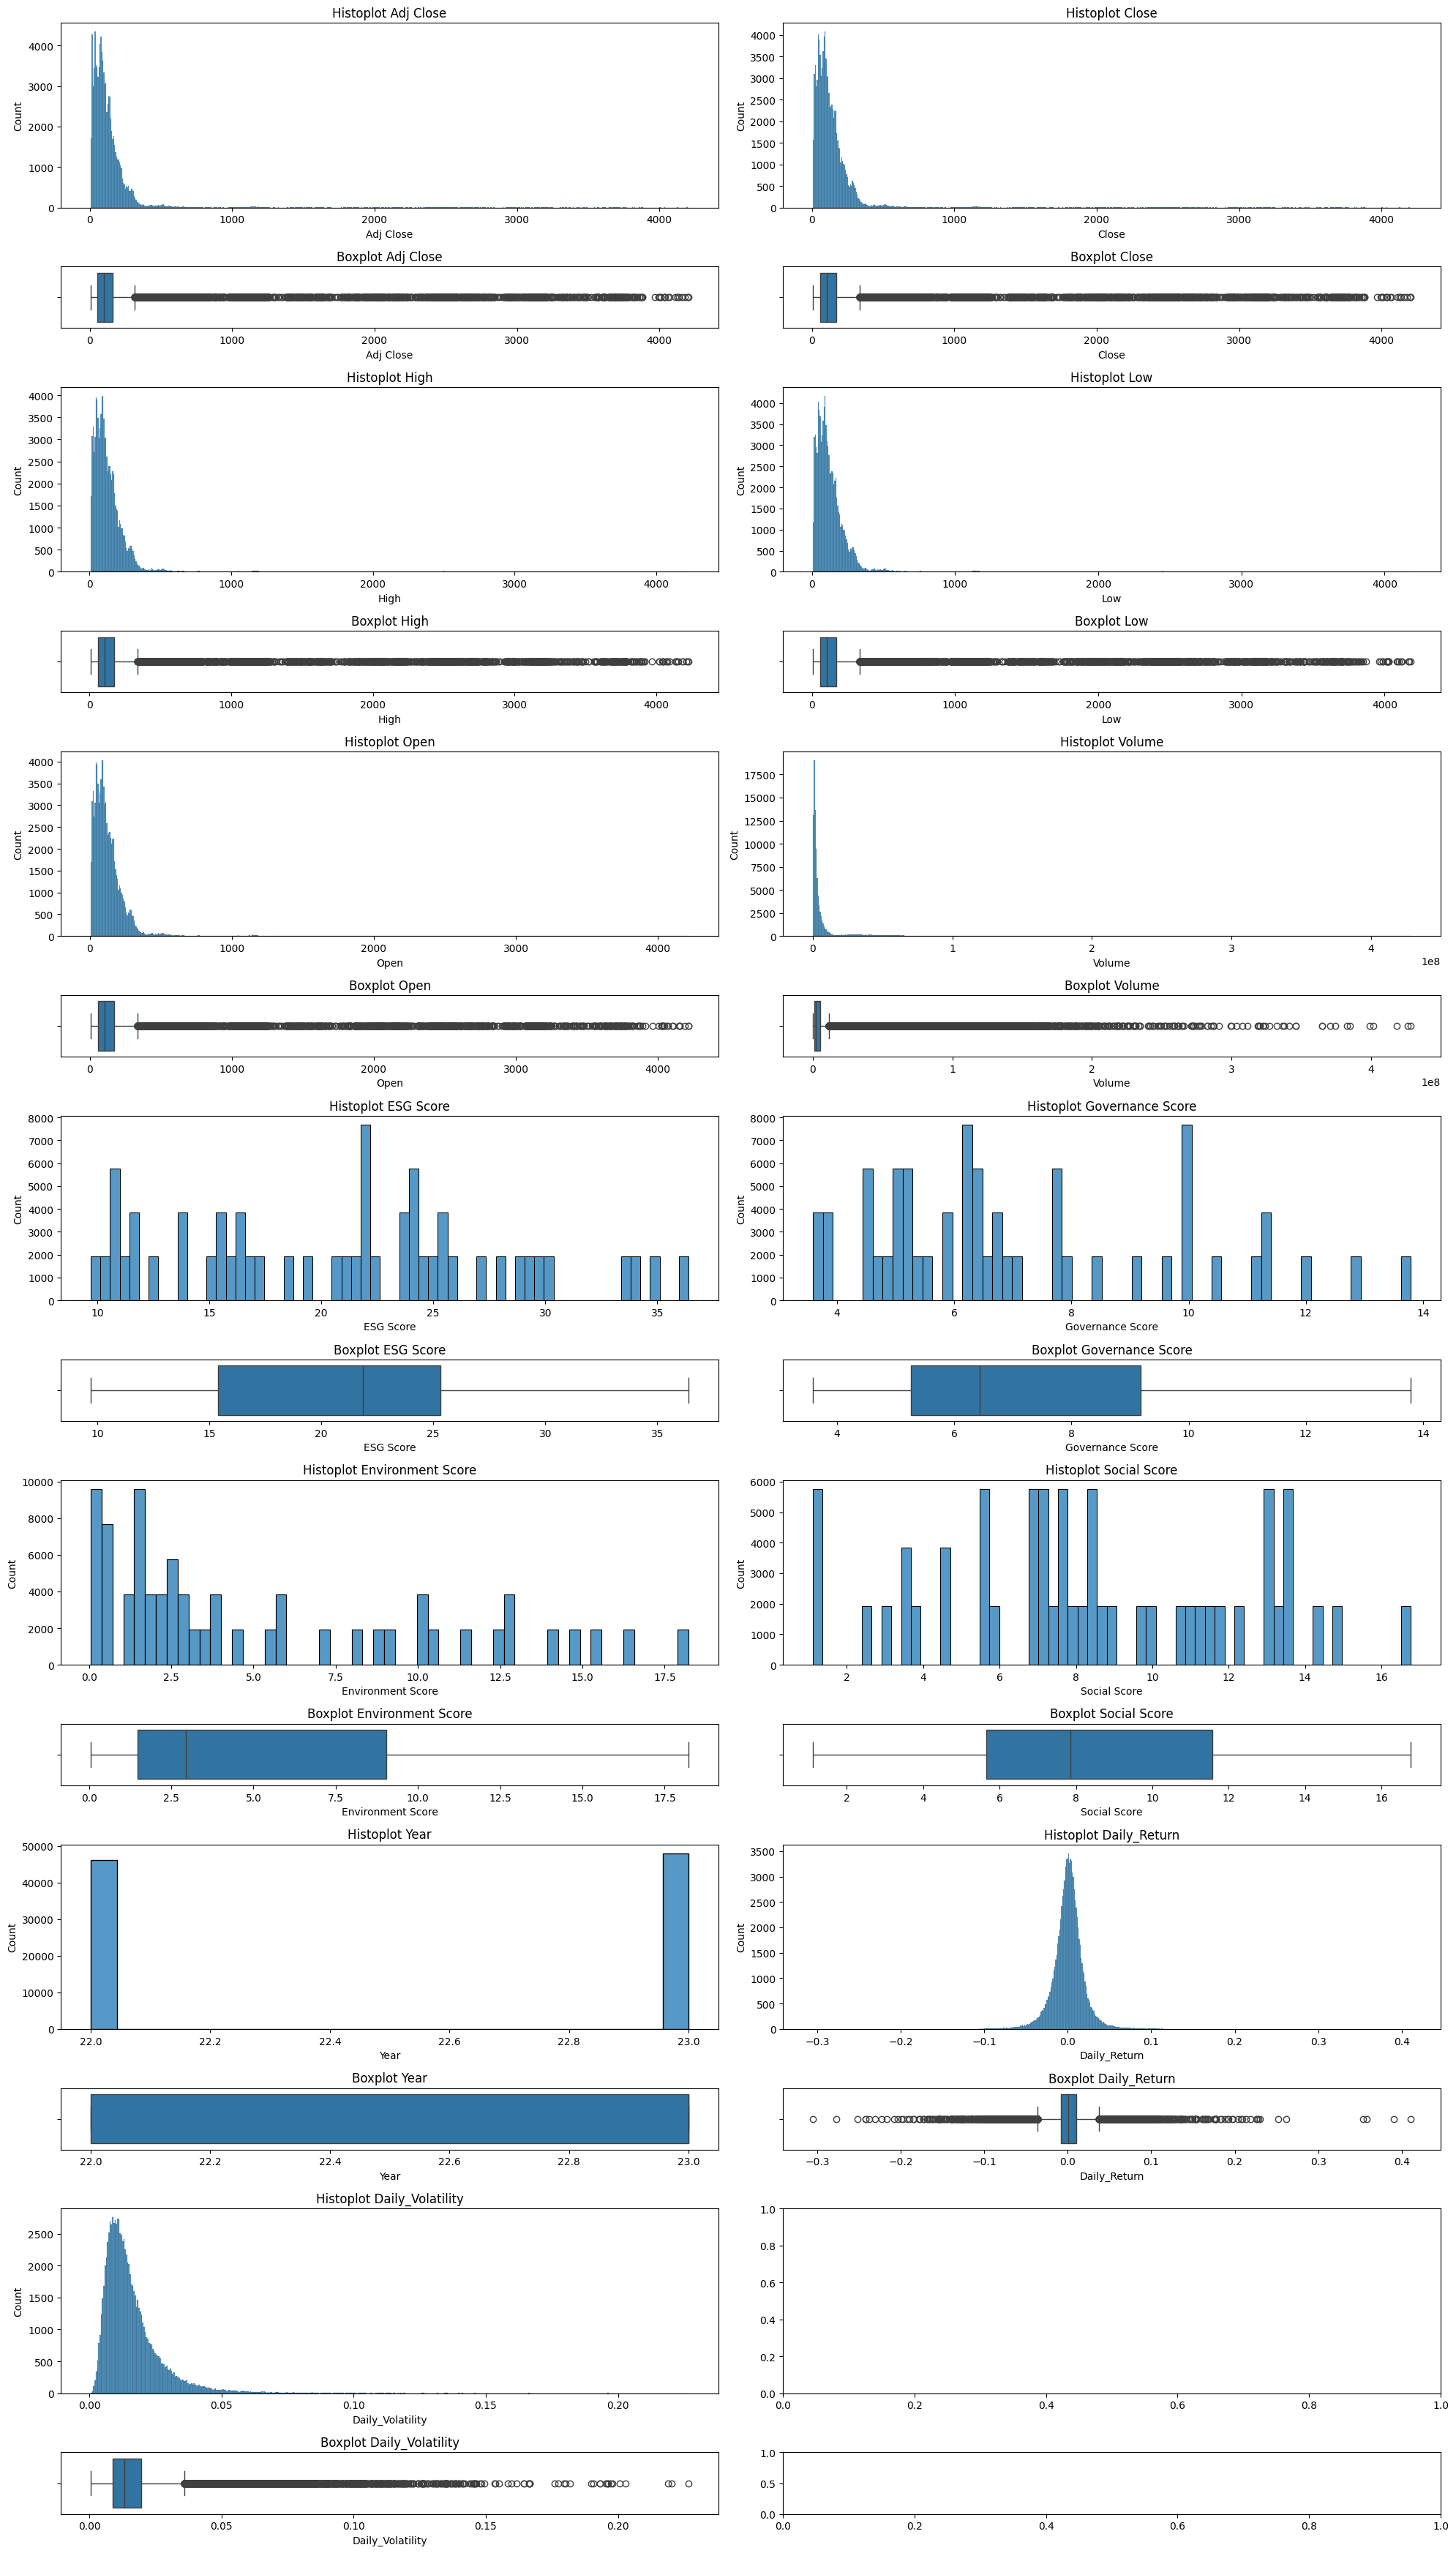

In [79]:
import matplotlib.pyplot as plt 
import seaborn as sns

numerical_variables = dataset_final.select_dtypes(include='number').columns
num_vars = len(numerical_variables)

# Number of rows: 2 per variable(histoplot + boxplot), 2 columns per row
ncols = 2
nrows = num_vars // ncols + (num_vars % ncols)
total_rows = nrows * 2  # double per variable.

fig, axes = plt.subplots(
    nrows=total_rows,
    ncols=ncols,
    figsize=(20, total_rows * 2.5),
    gridspec_kw={"height_ratios": [6, 2] * nrows}
)

axes = axes.reshape(total_rows, ncols)

# Automatic plot
for i, var in enumerate(numerical_variables):
    row = (i // ncols) * 2
    col = i % ncols

    # Histoplot
    sns.histplot(data=dataset_final, x=var, ax=axes[row, col])
    axes[row, col].set_title(f"Histoplot {var}")

    # Boxplot
    sns.boxplot(data=dataset_final, x=var, ax=axes[row + 1, col])
    axes[row + 1, col].set_title(f"Boxplot {var}")


plt.tight_layout()
plt.show()


In [80]:
# CATEGÓRICAS

categorical_variables = dataset_final.select_dtypes(include=['object', 'category']).columns.tolist()
print("Categorical Variables:", categorical_variables)

Categorical Variables: ['Ticker', 'ESG Score Date', 'ESG Status', 'CEO Gender']


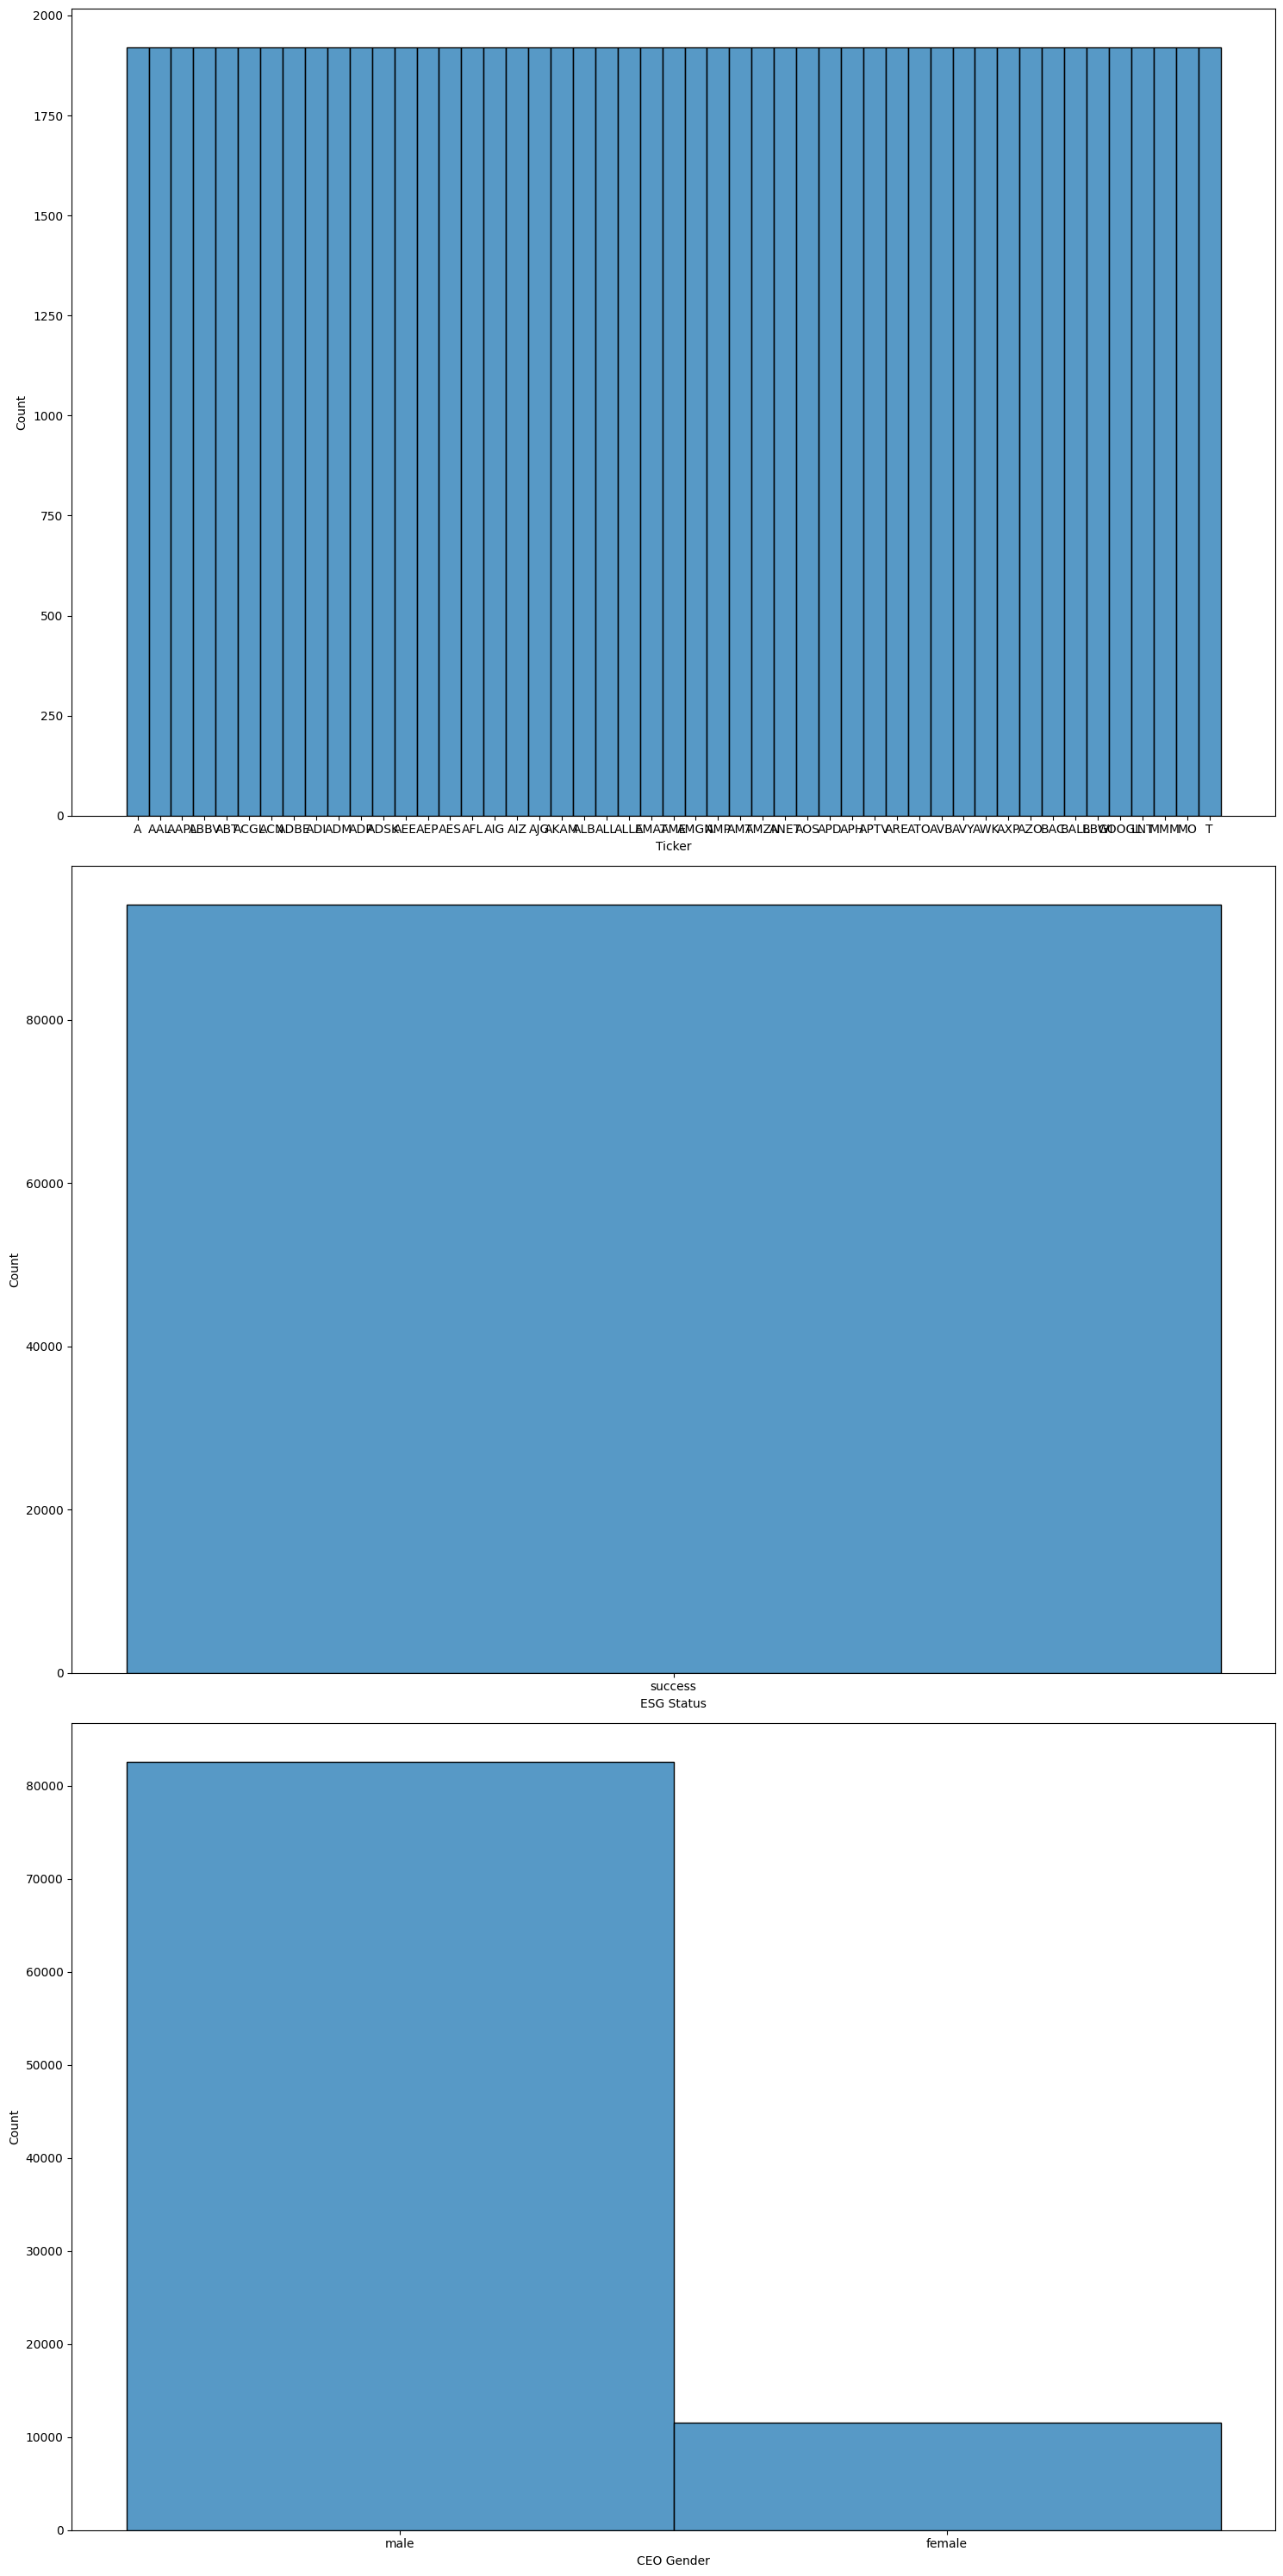

In [81]:

fig, axis = plt.subplots(3, figsize=(15, 30))

# Create a multiple histogram
sns.histplot(ax = axis[0], data = dataset_final, x = "Ticker") 
sns.histplot(ax = axis[1], data = dataset_final, x = "ESG Status")
sns.histplot(ax = axis[2], data = dataset_final, x = "CEO Gender")

plt.tight_layout()
plt.show()

In [82]:
#MULTIVARIANTE: numérico-numérico

numerical_variables

Index(['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume', 'ESG Score',
       'Governance Score', 'Environment Score', 'Social Score', 'Year',
       'Daily_Return', 'Daily_Volatility'],
      dtype='object')

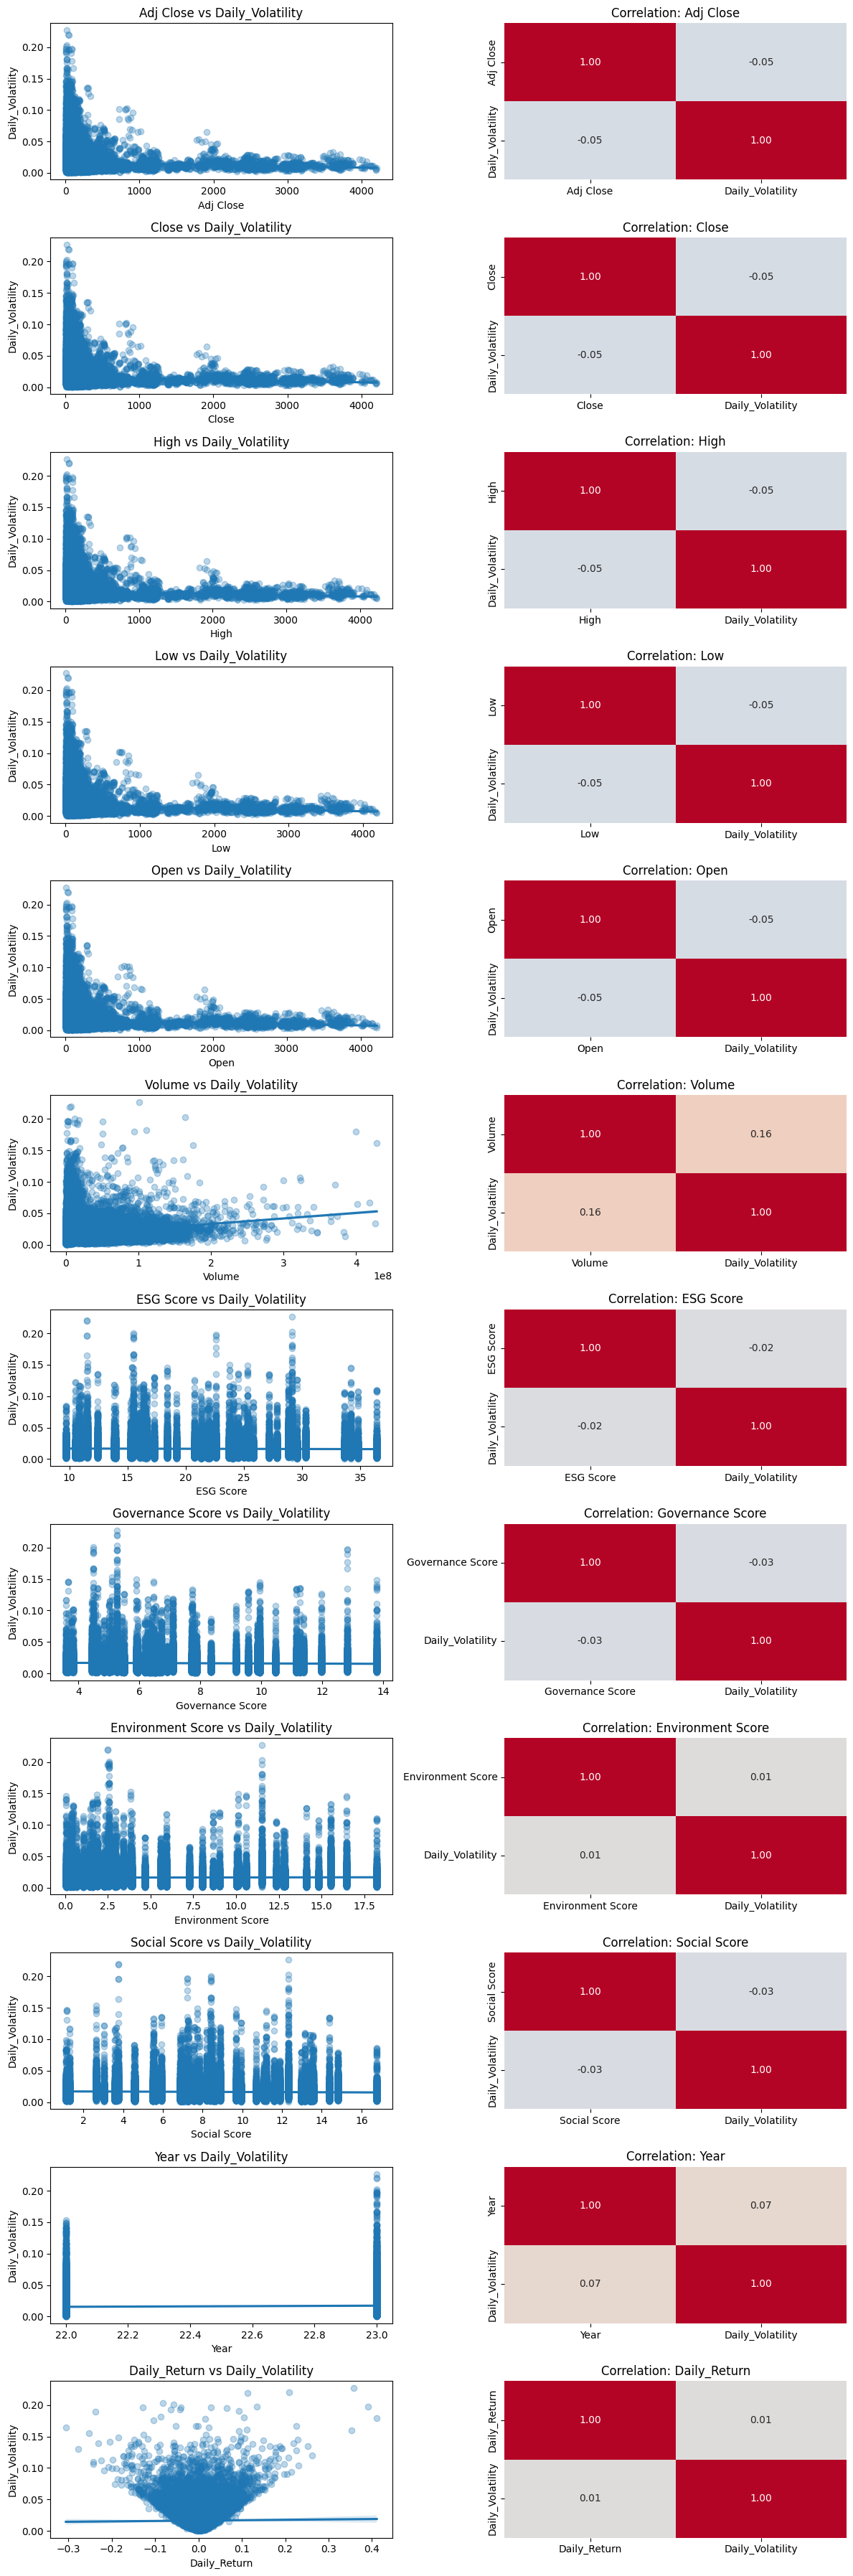

In [83]:
import matplotlib.pyplot as plt
import seaborn as sns

# Variables que quieres comparar con Daily_Volatility
variables = [
    "Adj Close", "Close", "High", "Low", "Open", "Volume",
    "ESG Score", "Governance Score", "Environment Score",
    "Social Score", "Year", "Daily_Return"
]

n_vars = len(variables)
ncols = 2   # un regplot y un heatmap por fila
nrows = n_vars  # una fila por variable

fig, axes = plt.subplots(
    nrows=nrows, 
    ncols=ncols, 
    figsize=(12, nrows * 3)
)

# Si solo hay 1 fila, convertir axes a 2D para que no dé error
if nrows == 1:
    axes = [axes]

for i, var in enumerate(variables):
    # Regplot a la izquierda
    sns.regplot(
        ax=axes[i, 0], 
        data=dataset_final, 
        x=var, 
        y="Daily_Volatility", 
        scatter_kws={"alpha": 0.3}
    )
    axes[i, 0].set_title(f"{var} vs Daily_Volatility")

    # Heatmap a la derecha
    corr = dataset_final[[var, "Daily_Volatility"]].corr()
    sns.heatmap(
        corr, 
        annot=True, 
        fmt=".2f", 
        ax=axes[i, 1], 
        cbar=False, 
        cmap="coolwarm",
        vmin=-1, vmax=1
    )
    axes[i, 1].set_title(f"Correlation: {var}")

plt.tight_layout()
plt.show()


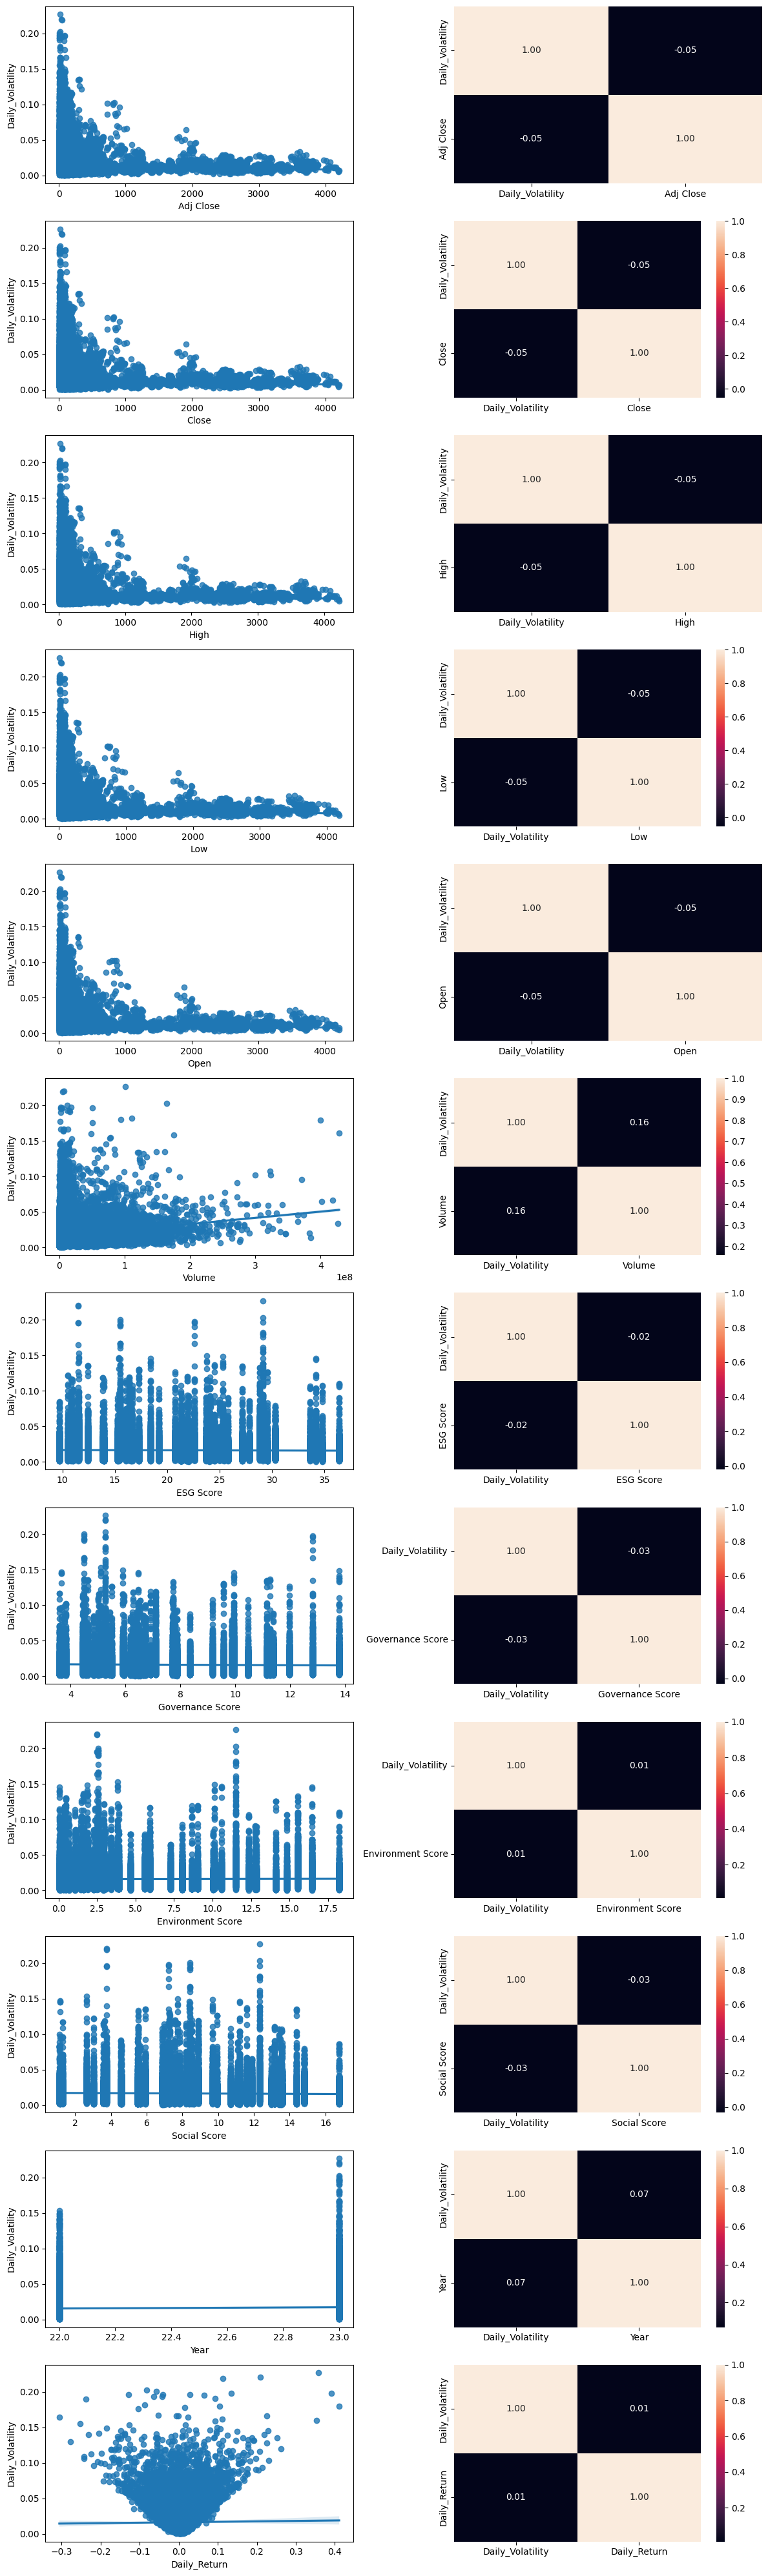

In [84]:
fig, axis = plt.subplots(12, 2, figsize=(12, 40))  # 12 variables → 12 filas x 2 columnas

sns.regplot(ax=axis[0, 0], data=dataset_final, x="Adj Close", y="Daily_Volatility")
sns.heatmap(dataset_final[["Daily_Volatility", "Adj Close"]].corr(), annot=True, fmt=".2f", ax=axis[0, 1], cbar=False)

sns.regplot(ax=axis[1, 0], data=dataset_final, x="Close", y="Daily_Volatility")
sns.heatmap(dataset_final[["Daily_Volatility", "Close"]].corr(), annot=True, fmt=".2f", ax=axis[1, 1])

sns.regplot(ax=axis[2, 0], data=dataset_final, x="High", y="Daily_Volatility")
sns.heatmap(dataset_final[["Daily_Volatility", "High"]].corr(), annot=True, fmt=".2f", ax=axis[2, 1], cbar=False)

sns.regplot(ax=axis[3, 0], data=dataset_final, x="Low", y="Daily_Volatility")
sns.heatmap(dataset_final[["Daily_Volatility", "Low"]].corr(), annot=True, fmt=".2f", ax=axis[3, 1])

sns.regplot(ax=axis[4, 0], data=dataset_final, x="Open", y="Daily_Volatility")
sns.heatmap(dataset_final[["Daily_Volatility", "Open"]].corr(), annot=True, fmt=".2f", ax=axis[4, 1], cbar=False)

sns.regplot(ax=axis[5, 0], data=dataset_final, x="Volume", y="Daily_Volatility")
sns.heatmap(dataset_final[["Daily_Volatility", "Volume"]].corr(), annot=True, fmt=".2f", ax=axis[5, 1])

sns.regplot(ax=axis[6, 0], data=dataset_final, x="ESG Score", y="Daily_Volatility")
sns.heatmap(dataset_final[["Daily_Volatility", "ESG Score"]].corr(), annot=True, fmt=".2f", ax=axis[6, 1])

sns.regplot(ax=axis[7, 0], data=dataset_final, x="Governance Score", y="Daily_Volatility")
sns.heatmap(dataset_final[["Daily_Volatility", "Governance Score"]].corr(), annot=True, fmt=".2f", ax=axis[7, 1])

sns.regplot(ax=axis[8, 0], data=dataset_final, x="Environment Score", y="Daily_Volatility")
sns.heatmap(dataset_final[["Daily_Volatility", "Environment Score"]].corr(), annot=True, fmt=".2f", ax=axis[8, 1])

sns.regplot(ax=axis[9, 0], data=dataset_final, x="Social Score", y="Daily_Volatility")
sns.heatmap(dataset_final[["Daily_Volatility", "Social Score"]].corr(), annot=True, fmt=".2f", ax=axis[9, 1])

sns.regplot(ax=axis[10, 0], data=dataset_final, x="Year", y="Daily_Volatility")
sns.heatmap(dataset_final[["Daily_Volatility", "Year"]].corr(), annot=True, fmt=".2f", ax=axis[10, 1])

sns.regplot(ax=axis[11, 0], data=dataset_final, x="Daily_Return", y="Daily_Volatility")
sns.heatmap(dataset_final[["Daily_Volatility", "Daily_Return"]].corr(), annot=True, fmt=".2f", ax=axis[11, 1])

plt.tight_layout()
plt.show()


MULTIVARIANTE CATEGÓRICO-CATEGÓRICO

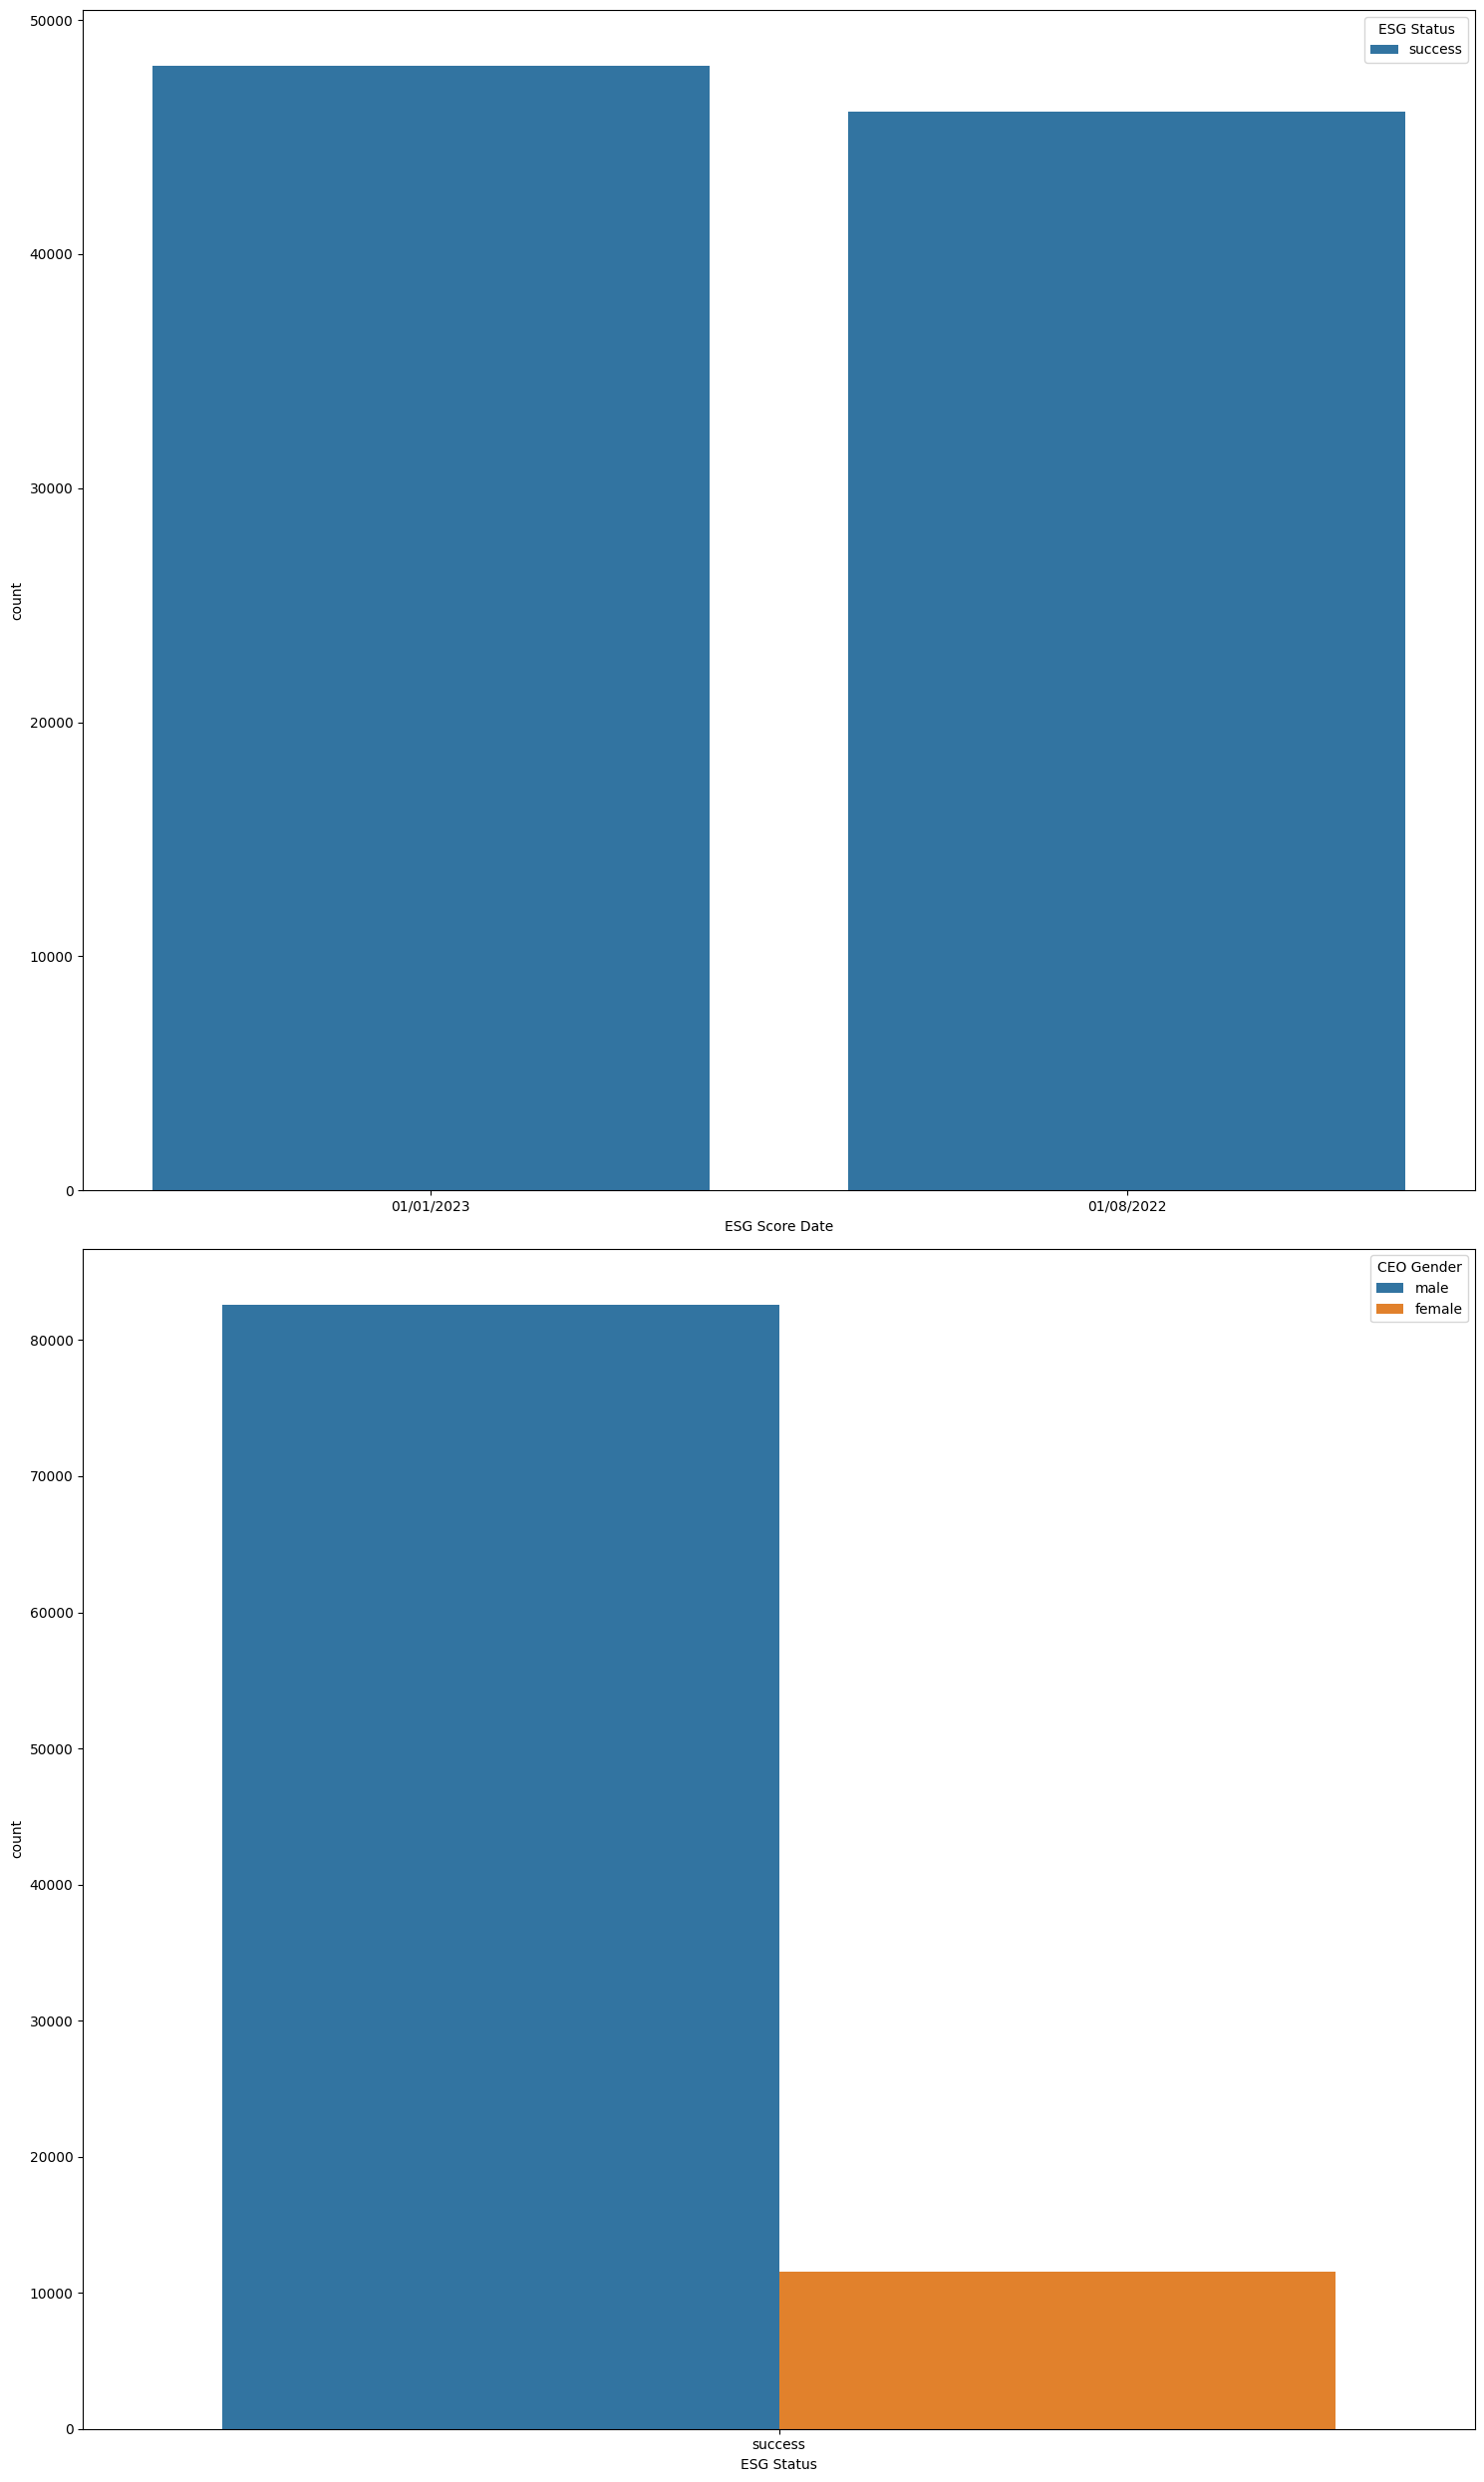

In [85]:
fig, axis = plt.subplots(2, 1, figsize=(15, 25))  

sns.countplot(data=dataset_final, x="ESG Score Date", hue="ESG Status", ax=axis[0])
sns.countplot(data=dataset_final, x="ESG Status", hue="CEO Gender", ax=axis[1])

plt.tight_layout()
plt.show()


## A revisar

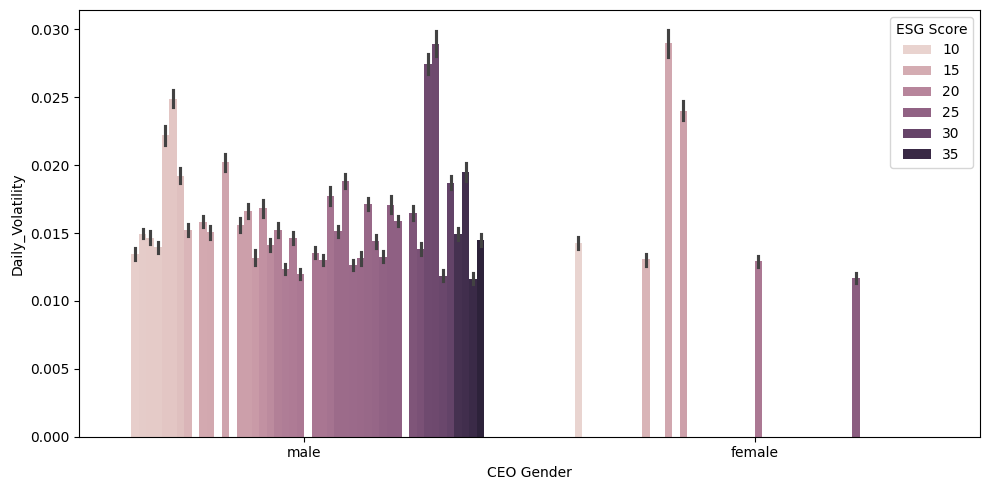

In [86]:
fig, axis = plt.subplots(figsize = (10, 5), ncols = 1)

sns.barplot(data = dataset_final, x = "CEO Gender", y = "Daily_Volatility", hue = "ESG Score")

plt.tight_layout()

plt.show()

# ANÁLISIS DE CORRELACIONES

In [87]:
import json 

categorical_f_rules = {}

for col in categorical_variables:
    encoded_col = f"{col}_n"
    dataset_final[encoded_col], uniques = pd.factorize(dataset_final[col])
    dicc = dict(zip(uniques, range(len(uniques))))
    categorical_f_rules[col] = dicc

with open("categorical_rules.json", "w") as f:
    json.dump(categorical_f_rules, f)

with open("categorical_rules.json", "r") as f:
    loaded_mappings = json.load(f)

dataset_final.head()

Date Ticker  Adj Close       Close        High        Low  \
245 2018-01-09      A  67.851929   71.769997   72.330002  70.169998   
246 2018-01-09    AAL  50.760616   52.080002   53.369999  52.009998   
247 2018-01-09   AAPL  40.866245   43.582500   43.764999  43.352501   
248 2018-01-09   ABBV  71.714798  100.239998  100.660004  98.699997   
249 2018-01-09    ABT  51.420967   58.919998   59.099998  58.380001   

          Open      Volume  ESG Score  Governance Score  ...  ESG Score Date  \
245  70.680000   2666100.0      15.24              6.26  ...      01/01/2023   
246  52.970001   3426000.0      29.10              5.26  ...      01/01/2023   
247  43.637501  86336000.0      16.68              9.18  ...      01/08/2022   
248  99.489998   4055400.0      27.84              9.95  ...      01/08/2022   
249  59.099998   7466900.0      24.98              8.36  ...      01/08/2022   

     ESG Status CEO Gender Year Daily_Return  Daily_Volatility  Ticker_n  \
245     success       male   23     0.024554          0.014419         0   
246     success       male   23    -0.000959          0.007580         1   
247     success       male   22    -0.000115          0.005833         2   
248     success       male   22     0.007539          0.014342         3   
249     success       male   22     0.001700          0.002566         4   

     ESG Score Date_n  ESG Status_n  CEO Gender_n  
245                 0             0             0  
246                 0             0             0  
247                 1             0             0  
248                 1             0             0  
249                 1             0             0  

[5 rows x 22 columns]

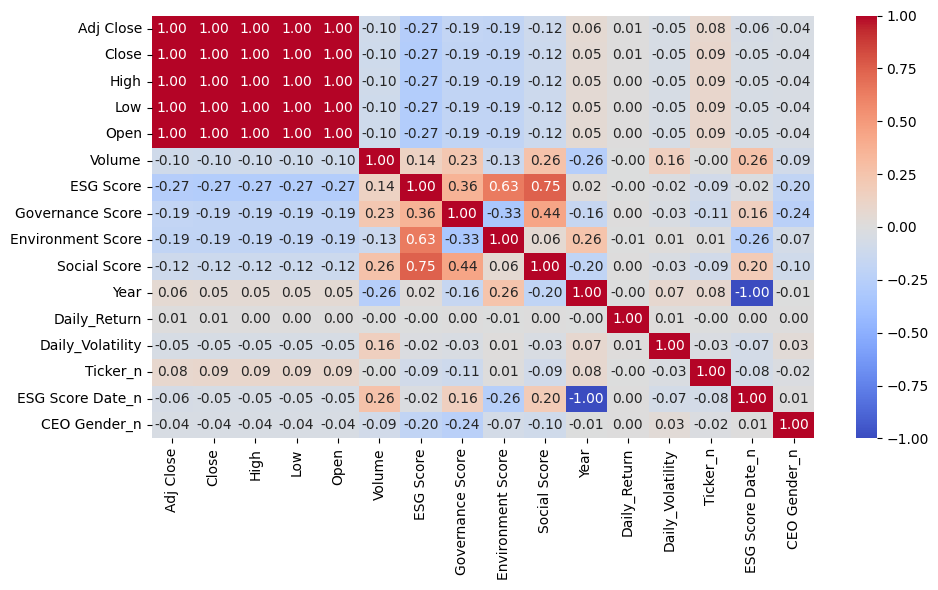

In [88]:
fig, axis = plt.subplots(figsize=(10, 6))

sns.heatmap(
    dataset_final[[
        "Adj Close", "Close", "High", "Low", "Open", "Volume",
        "ESG Score", "Governance Score", "Environment Score", "Social Score",
        "Year", "Daily_Return", "Daily_Volatility",
        "Ticker_n", "ESG Score Date_n",
        "CEO Gender_n"
    ]].corr(),
    annot=True,
    fmt=".2f",
    cmap="coolwarm"
)

plt.tight_layout()
plt.show()


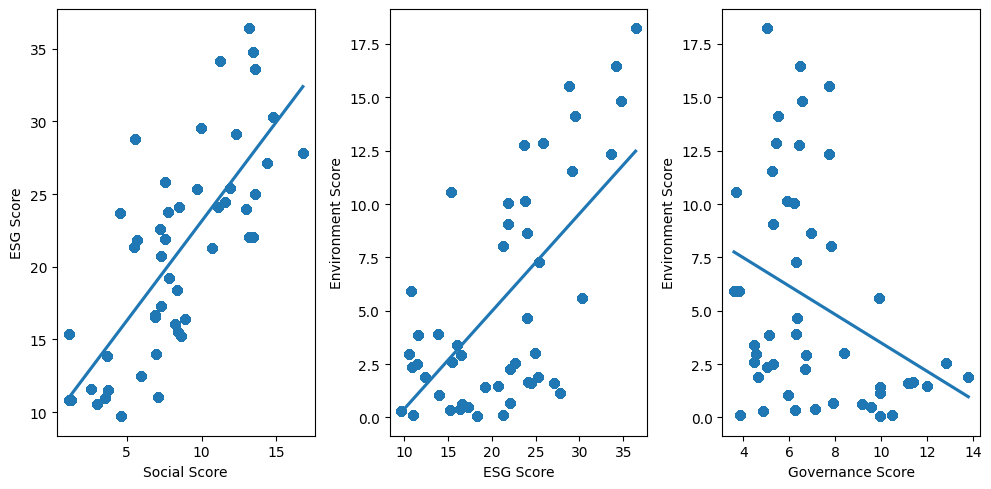

In [89]:
fig, axis = plt.subplots(figsize = (10, 5), ncols = 3)
sns.regplot(ax = axis[0], data = dataset_final, x = "Social Score", y = "ESG Score")
sns.regplot(ax = axis[1], data = dataset_final, x = "ESG Score", y = "Environment Score")
sns.regplot(ax = axis[2], data = dataset_final, x = "Governance Score", y = "Environment Score")

plt.tight_layout()
plt.show()

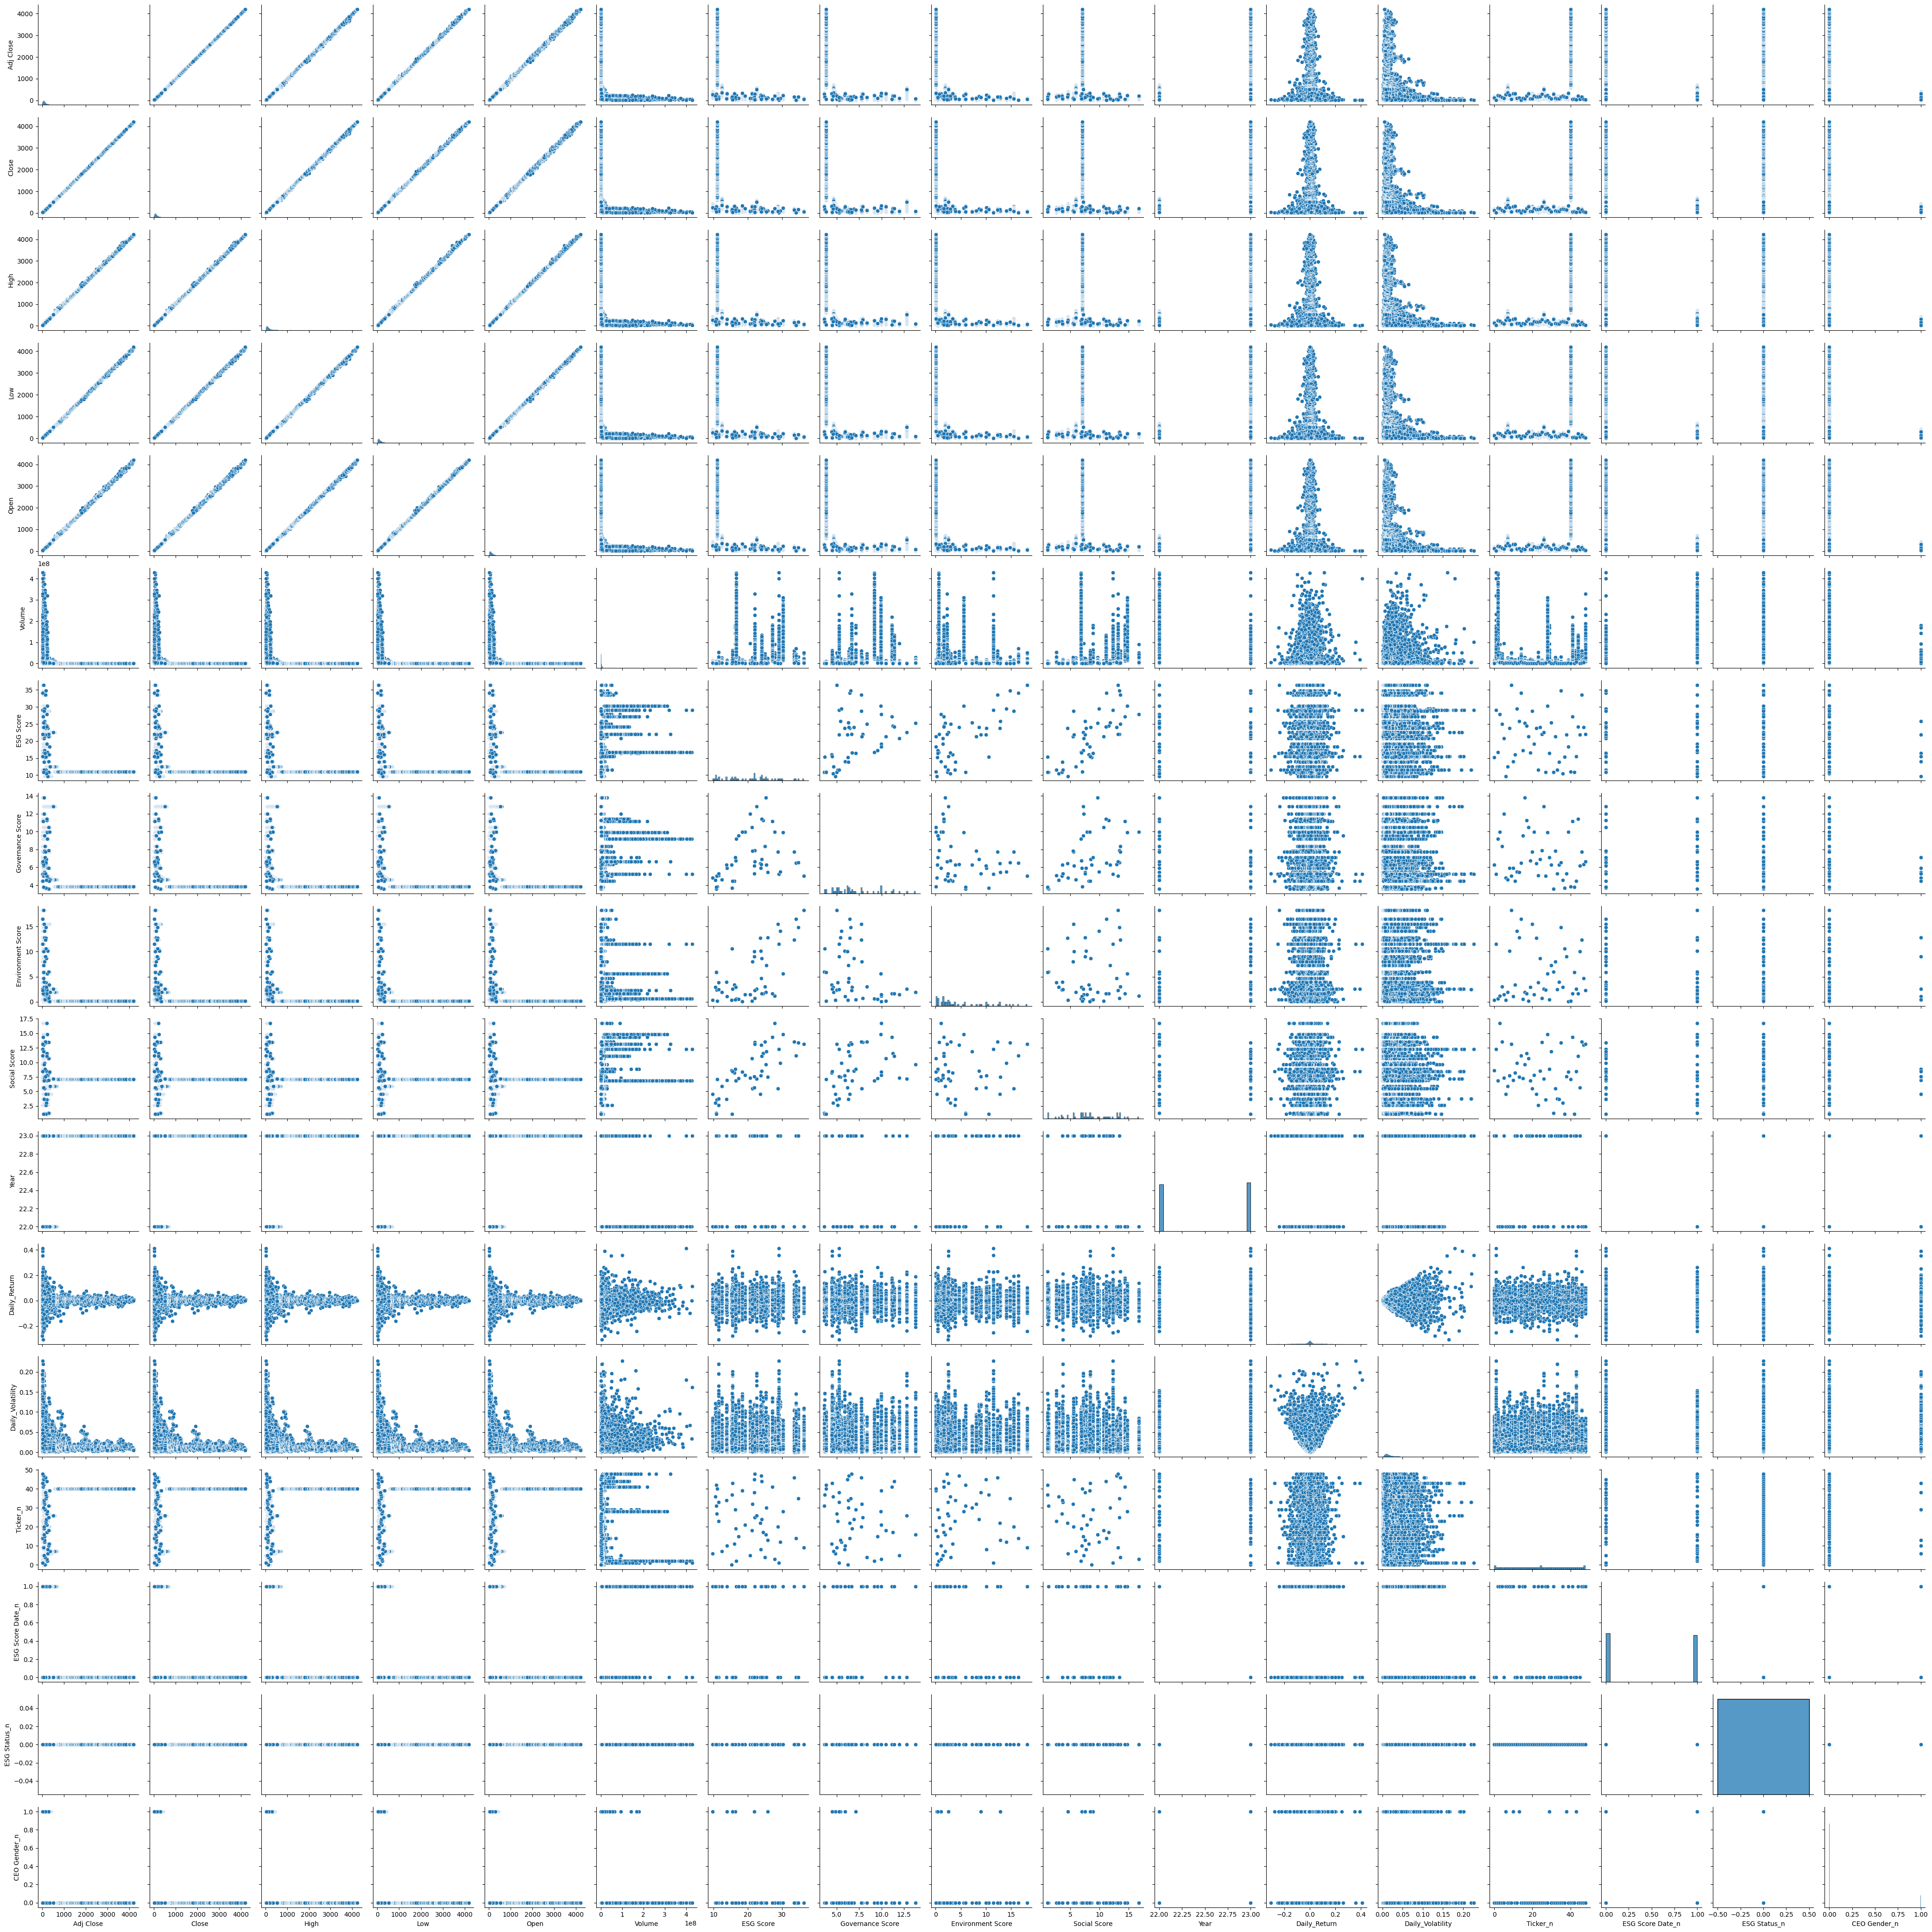

In [90]:
sns.pairplot(data = dataset_final)

In [91]:
dataset_final.describe()

Date     Adj Close         Close  \
count                          94129  94129.000000  94129.000000   
mean   2021-11-02 08:13:14.586152960    152.382872    159.591134   
min              2018-01-09 00:00:00      6.781555      7.413096   
25%              2019-12-05 00:00:00     54.170822     58.808498   
50%              2021-11-01 00:00:00     97.430313    104.320000   
75%              2023-09-29 00:00:00    159.060257    169.880005   
max              2025-08-29 00:00:00   4205.410156   4205.410156   
std                              NaN    298.454138    298.066856   

               High           Low          Open        Volume     ESG Score  \
count  94129.000000  94129.000000  94129.000000  9.412900e+04  94129.000000   
mean     161.276196    157.801603    159.558131  9.406241e+06     20.921020   
min        7.881973      6.467259      7.631366  3.750000e+04      9.710000   
25%       59.439999     58.169998     58.799500  1.097700e+06     15.380000   
50%      105.379997    103.129997    104.300003  2.215100e+06     21.870000   
75%      171.559998    168.169998    169.832779  5.254500e+06     25.320000   
max     4229.680176   4182.259766   4216.020020  4.286171e+08     36.400000   
std      300.864680    294.903649    297.852151  2.262586e+07      7.098445   

       Governance Score  Environment Score  Social Score          Year  \
count      94129.000000       94129.000000  94129.000000  94129.000000   
mean           7.154490           5.382449      8.384286     22.510204   
min            3.590000           0.050000      1.110000     22.000000   
25%            5.260000           1.470000      5.650000     22.000000   
50%            6.430000           2.950000      7.850000     23.000000   
75%            9.180000           9.040000     11.580000     23.000000   
max           13.790000          18.230000     16.770000     23.000000   
std            2.571811           5.134039      3.886242      0.499899   

       Daily_Return  Daily_Volatility      Ticker_n  ESG Score Date_n  \
count  94129.000000      94129.000000  94129.000000      94129.000000   
mean       0.000602          0.016314     24.000000          0.489796   
min       -0.305527          0.000479      0.000000          0.000000   
25%       -0.008378          0.008870     12.000000          0.000000   
50%        0.000917          0.013160     24.000000          0.000000   
75%        0.009996          0.019666     36.000000          1.000000   
max        0.410970          0.226741     48.000000          1.000000   
std        0.020392          0.012592     14.142211          0.499899   

       ESG Status_n  CEO Gender_n  
count       94129.0  94129.000000  
mean            0.0      0.122449  
min             0.0      0.000000  
25%             0.0      0.000000  
50%             0.0      0.000000  
75%             0.0      0.000000  
max             0.0      1.000000  
std             0.0      0.327805

OUTLIERS

In [92]:
dataset_final.describe()

Date     Adj Close         Close  \
count                          94129  94129.000000  94129.000000   
mean   2021-11-02 08:13:14.586152960    152.382872    159.591134   
min              2018-01-09 00:00:00      6.781555      7.413096   
25%              2019-12-05 00:00:00     54.170822     58.808498   
50%              2021-11-01 00:00:00     97.430313    104.320000   
75%              2023-09-29 00:00:00    159.060257    169.880005   
max              2025-08-29 00:00:00   4205.410156   4205.410156   
std                              NaN    298.454138    298.066856   

               High           Low          Open        Volume     ESG Score  \
count  94129.000000  94129.000000  94129.000000  9.412900e+04  94129.000000   
mean     161.276196    157.801603    159.558131  9.406241e+06     20.921020   
min        7.881973      6.467259      7.631366  3.750000e+04      9.710000   
25%       59.439999     58.169998     58.799500  1.097700e+06     15.380000   
50%      105.379997    103.129997    104.300003  2.215100e+06     21.870000   
75%      171.559998    168.169998    169.832779  5.254500e+06     25.320000   
max     4229.680176   4182.259766   4216.020020  4.286171e+08     36.400000   
std      300.864680    294.903649    297.852151  2.262586e+07      7.098445   

       Governance Score  Environment Score  Social Score          Year  \
count      94129.000000       94129.000000  94129.000000  94129.000000   
mean           7.154490           5.382449      8.384286     22.510204   
min            3.590000           0.050000      1.110000     22.000000   
25%            5.260000           1.470000      5.650000     22.000000   
50%            6.430000           2.950000      7.850000     23.000000   
75%            9.180000           9.040000     11.580000     23.000000   
max           13.790000          18.230000     16.770000     23.000000   
std            2.571811           5.134039      3.886242      0.499899   

       Daily_Return  Daily_Volatility      Ticker_n  ESG Score Date_n  \
count  94129.000000      94129.000000  94129.000000      94129.000000   
mean       0.000602          0.016314     24.000000          0.489796   
min       -0.305527          0.000479      0.000000          0.000000   
25%       -0.008378          0.008870     12.000000          0.000000   
50%        0.000917          0.013160     24.000000          0.000000   
75%        0.009996          0.019666     36.000000          1.000000   
max        0.410970          0.226741     48.000000          1.000000   
std        0.020392          0.012592     14.142211          0.499899   

       ESG Status_n  CEO Gender_n  
count       94129.0  94129.000000  
mean            0.0      0.122449  
min             0.0      0.000000  
25%             0.0      0.000000  
50%             0.0      0.000000  
75%             0.0      0.000000  
max             0.0      1.000000  
std             0.0      0.327805

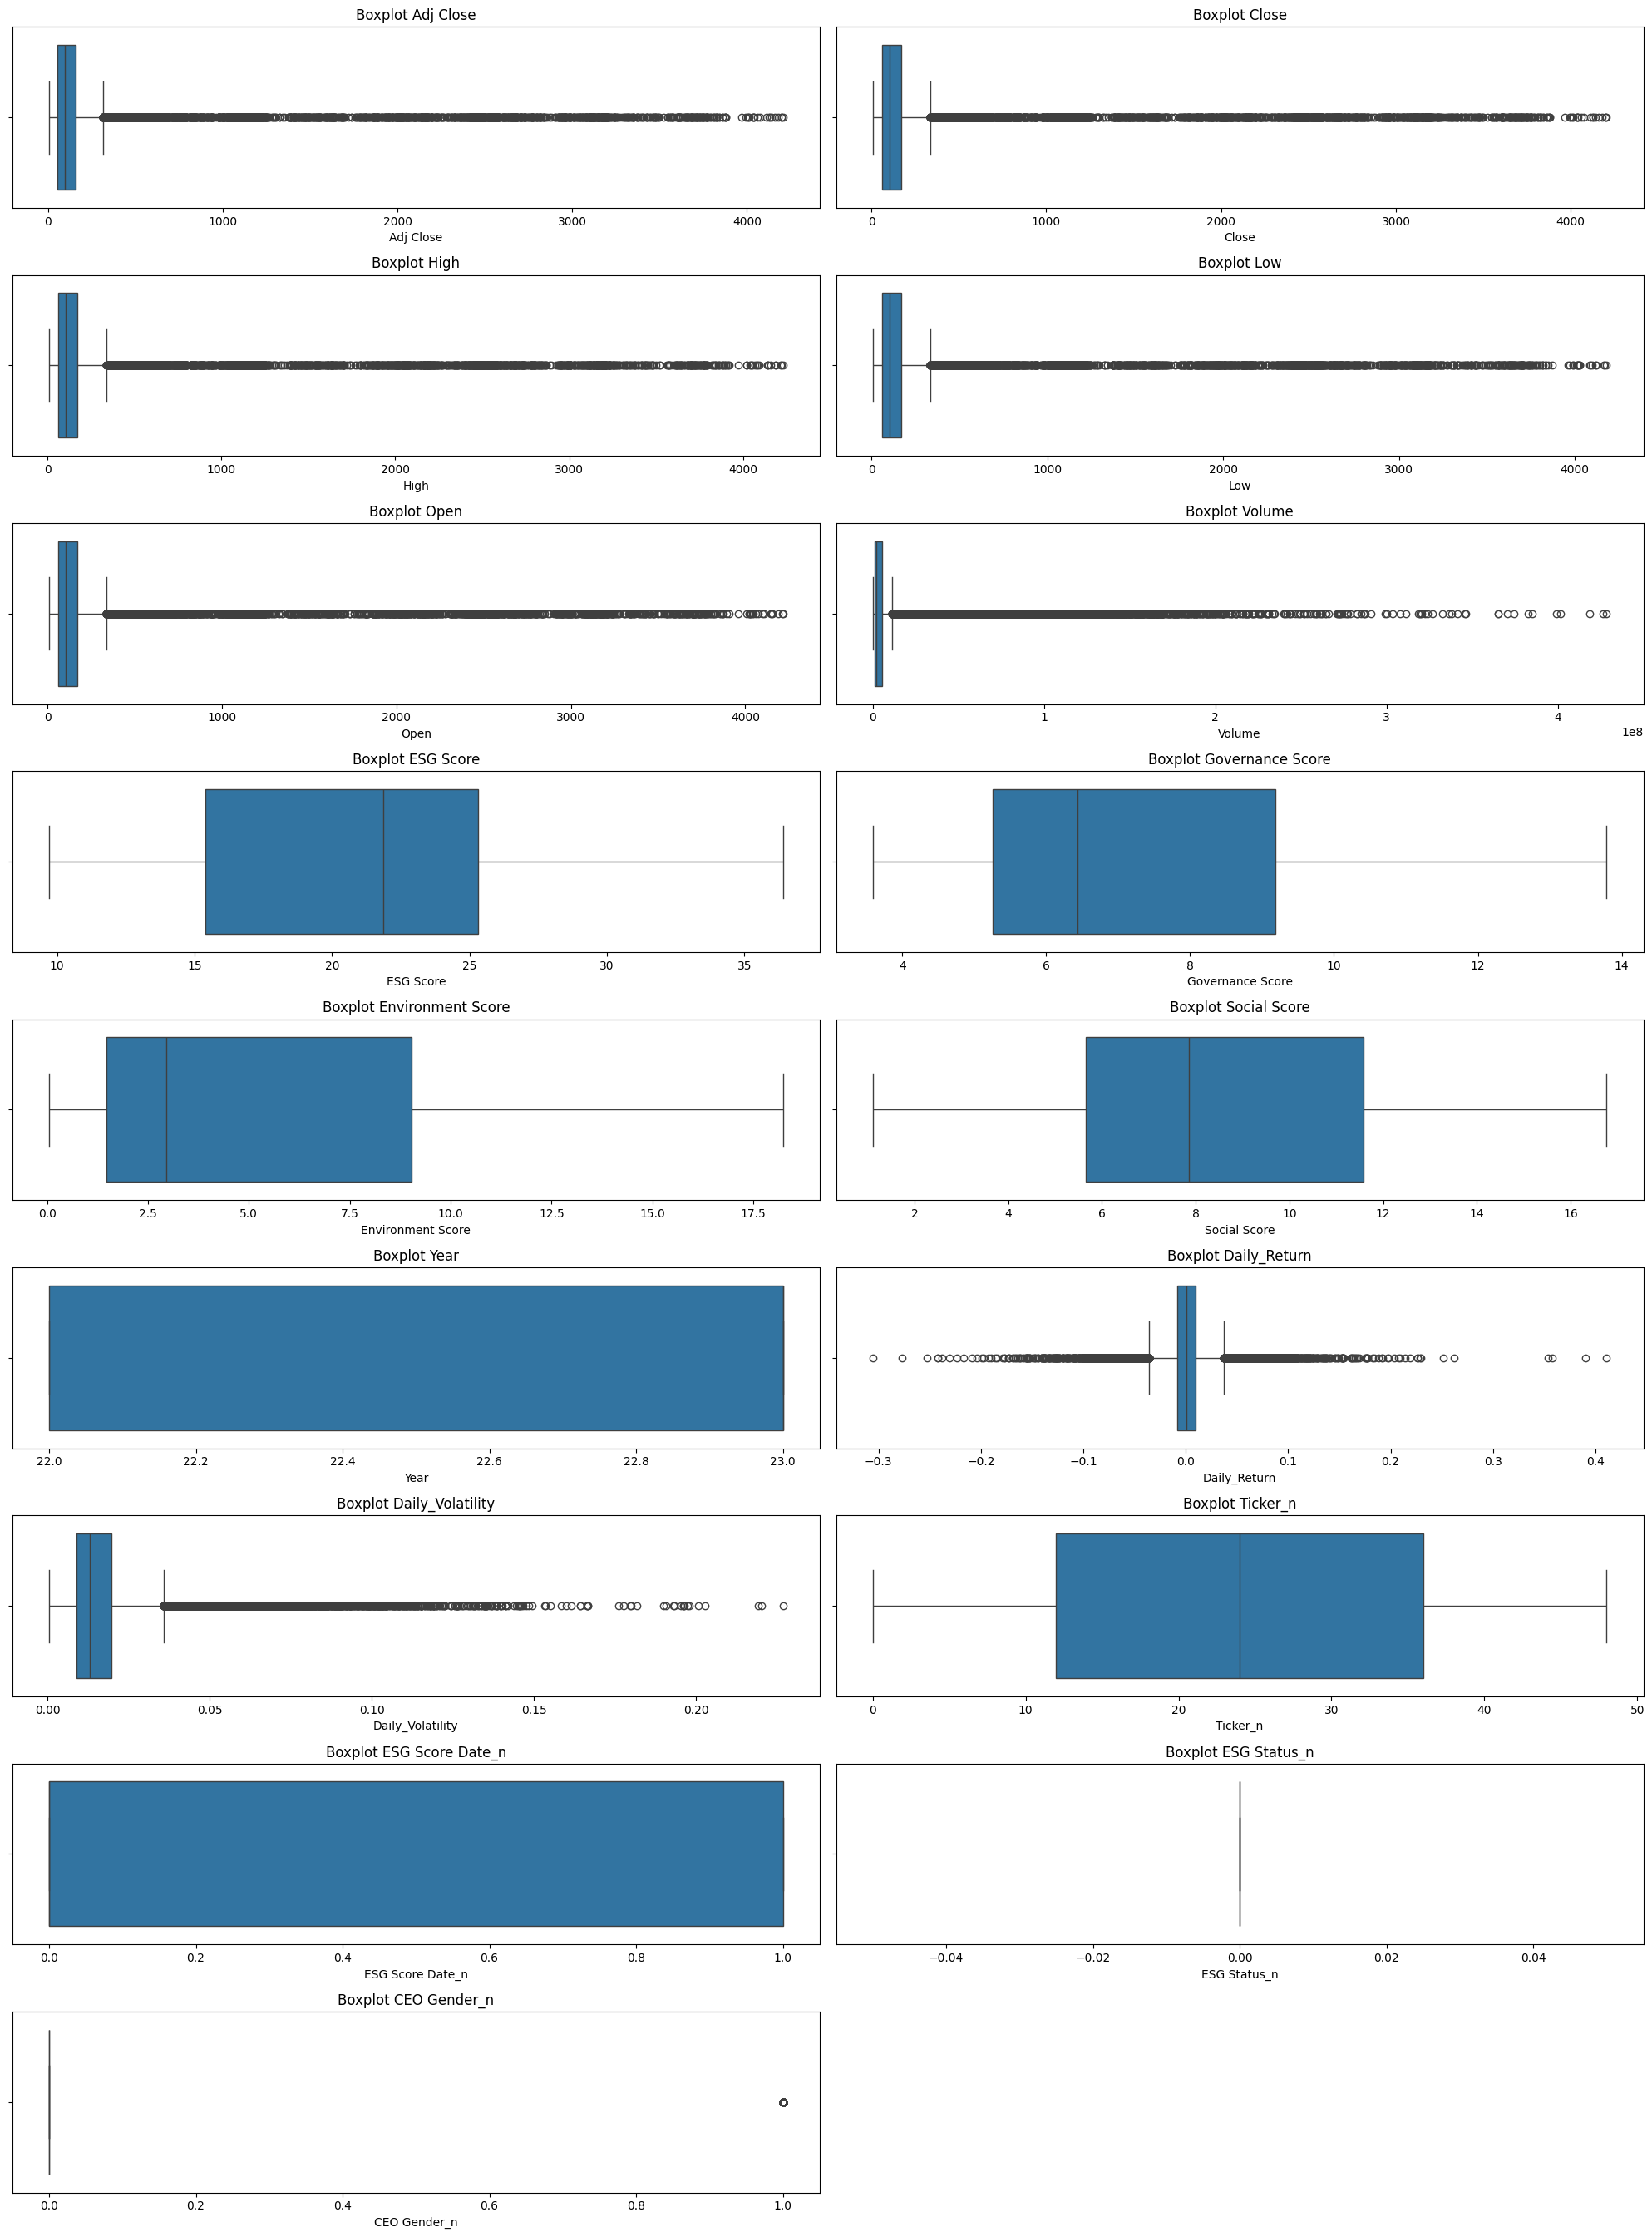

In [93]:
numerical_variables = dataset_final.select_dtypes(include='number').columns
num_vars = len(numerical_variables)# Definir grid
ncols = 2
nrows = num_vars // ncols + (num_vars % ncols)

fig, axes = plt.subplots(
    nrows=nrows,
    ncols=ncols,
    figsize=(20, nrows * 3)
)

axes = axes.flatten()# Solo boxplots
for i, var in enumerate(numerical_variables):
    sns.boxplot(data=dataset_final, x=var, ax=axes[i])
    axes[i].set_title(f"Boxplot {var}") # Eliminar ejes vacíos si sobran
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])
    
plt.tight_layout()
plt.show()

Eliminar factorizados

In [94]:
numerical_columns = [
   'Adj Close', 
   'Close', 
   'High', 
   'Low', 
   'Open', 
   'Volume', 
   'ESG Score',
   'Governance Score', 
   'Environment Score', 
   'Social Score', 
   'Year',
   'Daily_Return'
]

for column in numerical_columns:
    stats = dataset_final[column].describe()
    iqr = stats["75%"] - stats["25%"]
    upper_limit = stats["75%"] + 1.5 * iqr
    lower_limit = stats["25%"] - 1.5 * iqr
    if lower_limit < 0:
      lower_limit = 0
    
    outliers = dataset_final[(dataset_final[column] < lower_limit) | (dataset_final[column] > upper_limit)]
    outlier_count = outliers.shape[0]

    print(f"{column.capitalize()} — IQR: {round(iqr, 2)}, Upper limits: {round(upper_limit, 2)}, Lowerlimits: {round(lower_limit, 2)}")
    print(f"Total de outliers: {outlier_count}\n")

Adj close — IQR: 104.89, Upper limits: 316.39, Lowerlimits: 0
Total de outliers: 4492

Close — IQR: 111.07, Upper limits: 336.49, Lowerlimits: 0
Total de outliers: 4109

High — IQR: 112.12, Upper limits: 339.74, Lowerlimits: 0
Total de outliers: 4105

Low — IQR: 110.0, Upper limits: 333.17, Lowerlimits: 0
Total de outliers: 4101

Open — IQR: 111.03, Upper limits: 336.38, Lowerlimits: 0
Total de outliers: 4105

Volume — IQR: 4156800.0, Upper limits: 11489700.0, Lowerlimits: 0
Total de outliers: 13150

Esg score — IQR: 9.94, Upper limits: 40.23, Lowerlimits: 0.47
Total de outliers: 0

Governance score — IQR: 3.92, Upper limits: 15.06, Lowerlimits: 0
Total de outliers: 0

Environment score — IQR: 7.57, Upper limits: 20.39, Lowerlimits: 0
Total de outliers: 0

Social score — IQR: 5.93, Upper limits: 20.48, Lowerlimits: 0
Total de outliers: 0

Year — IQR: 1.0, Upper limits: 24.5, Lowerlimits: 20.5
Total de outliers: 0

Daily_return — IQR: 0.02, Upper limits: 0.04, Lowerlimits: 0
Total de ou

In [95]:
dataset_final.isnull().sum().sort_values(ascending=False) / len(dataset_final)

Date                 0.0
Ticker               0.0
Adj Close            0.0
Close                0.0
High                 0.0
Low                  0.0
Open                 0.0
Volume               0.0
ESG Score            0.0
Governance Score     0.0
Environment Score    0.0
Social Score         0.0
ESG Score Date       0.0
ESG Status           0.0
CEO Gender           0.0
Year                 0.0
Daily_Return         0.0
Daily_Volatility     0.0
Ticker_n             0.0
ESG Score Date_n     0.0
ESG Status_n         0.0
CEO Gender_n         0.0
dtype: float64

# SPLIT TRAIN/TEST #

In [96]:
from sklearn.model_selection import train_test_split


num_variables = ['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume', 'ESG Score','Governance Score', 'Environment Score', 'Social Score', 'Year', 'Daily_Return', 'Ticker_n', 'ESG Score Date_n', 'ESG Status_n', 'CEO Gender_n']

X = dataset_final.drop("Daily_Volatility", axis = 1)[num_variables]
y = dataset_final["Daily_Volatility"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

X_train.head()

Adj Close       Close        High         Low        Open      Volume  \
78402  185.202682  186.279999  187.100006  184.619995  185.440002  72044800.0   
56898   78.584396   86.599998   86.669998   84.510002   84.610001   2339300.0   
43142  132.109787  140.210007  140.919998  139.779999  140.179993    430100.0   
31795   18.148241   19.838320   20.339531   19.547293   20.024252  13065441.0   
67208   42.270000   42.270000   42.290001   41.102501   41.660000  10488800.0   

       ESG Score  Governance Score  Environment Score  Social Score  Year  \
78402      16.68              9.18               0.65          6.86    22   
56898      36.40              5.01              18.23         13.16    22   
43142      23.72              6.43              12.75          4.54    23   
31795      15.50              4.48               2.59          8.43    23   
67208      16.40              7.11               0.40          8.88    23   

       Daily_Return  Ticker_n  ESG Score Date_n  ESG Status_n  CEO Gender_n  
78402      0.017645         2                 1             0             0  
56898      0.029237         9                 1             0             0  
43142      0.006533        22                 0             0             0  
31795     -0.051777        43                 0             0             1  
67208      0.002847        29                 0             0             1

## NORMALIZACION ##

In [97]:
from sklearn.preprocessing import StandardScaler
import pickle

normalizador= StandardScaler()
normalizador.fit(X_train)

X_train_norm = normalizador.transform(X_train)
X_train_norm = pd.DataFrame(X_train_norm, index = X_train.index, columns = num_variables)

X_test_norm = normalizador.transform(X_test)
X_test_norm = pd.DataFrame(X_test_norm, index = X_test.index, columns = num_variables)

X_train_norm.head()

Adj Close     Close      High       Low      Open    Volume  ESG Score  \
78402   0.108107  0.087883  0.084184  0.089258  0.085219  2.732895  -0.595188   
56898  -0.246663 -0.244238 -0.247286 -0.247859 -0.250910 -0.311829   2.181911   
43142  -0.068559 -0.065616 -0.068233 -0.061739 -0.065661 -0.395222   0.396230   
31795  -0.447764 -0.466680 -0.466211 -0.466619 -0.466215  0.156687  -0.761364   
67208  -0.367499 -0.391940 -0.393763 -0.394033 -0.394089  0.044140  -0.634620   

       Governance Score  Environment Score  Social Score      Year  \
78402          0.784747          -0.919639     -0.391050 -1.016456   
56898         -0.834011           2.506094      1.231031 -1.016456   
43142         -0.282779           1.438232     -0.988387  0.983810   
31795         -1.039753          -0.541600      0.013183  0.983810   
67208         -0.018809          -0.968355      0.129046  0.983810   

       Daily_Return  Ticker_n  ESG Score Date_n  ESG Status_n  CEO Gender_n  
78402      0.833235 -1.554762          1.016456           0.0     -0.375140  
56898      1.400948 -1.060063          1.016456           0.0     -0.375140  
43142      0.288978 -0.141337         -0.983810           0.0     -0.375140  
31795     -2.566927  1.342759         -0.983810           0.0      2.665673  
67208      0.108439  0.353362         -0.983810           0.0      2.665673

## MIN MAX SCALER ##

In [98]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(X_train)

X_train_scal = scaler.transform(X_train)
X_train_scal = pd.DataFrame(X_train_scal, index = X_train.index, columns = num_variables)

X_test_scal = scaler.transform(X_test)
X_test_scal = pd.DataFrame(X_test_scal, index = X_test.index, columns = num_variables)

X_train_scal.head()

Adj Close     Close      High       Low      Open    Volume  ESG Score  \
78402   0.042495  0.042608  0.042451  0.042650  0.042251  0.168014   0.261146   
56898   0.017101  0.018863  0.018662  0.018676  0.018292  0.005371   1.000000   
43142   0.029850  0.031633  0.031512  0.031912  0.031496  0.000916   0.524916   
31795   0.002707  0.002960  0.002951  0.003119  0.002945  0.030398   0.216935   
67208   0.008452  0.008303  0.008150  0.008281  0.008086  0.024386   0.250656   

       Governance Score  Environment Score  Social Score  Year  Daily_Return  \
78402          0.548039           0.033003      0.367178   0.0      0.428527   
56898          0.139216           1.000000      0.769476   0.0      0.445369   
43142          0.278431           0.698570      0.219029   1.0      0.412382   
31795          0.087255           0.139714      0.467433   1.0      0.327661   
67208          0.345098           0.019252      0.496169   1.0      0.407026   

       Ticker_n  ESG Score Date_n  ESG Status_n  CEO Gender_n  
78402  0.041667               1.0           0.0           0.0  
56898  0.187500               1.0           0.0           0.0  
43142  0.458333               0.0           0.0           0.0  
31795  0.895833               0.0           0.0           1.0  
67208  0.604167               0.0           0.0           1.0

In [99]:
from sklearn.preprocessing import StandardScaler
import numpy as np

# Columnas
fin_columns = ['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume', 'Year', 'Daily_Return', 'Ticker_n']
esg_columns = ['ESG Score', 'Governance Score', 'Environment Score', 'Social Score', 
               'ESG Score Date_n', 'ESG Status_n', 'CEO Gender_n', 'Ticker_n']

# Escalar cada grupo
scaler_fin = StandardScaler()
X_fin_scaled = scaler_fin.fit_transform(X_train[fin_columns])
X_fin_scaled_test = scaler_fin.transform(X_test[fin_columns])

scaler_esg = StandardScaler()
X_esg_scaled = scaler_esg.fit_transform(X_train[esg_columns])
X_esg_scaled_test = scaler_esg.transform(X_test[esg_columns])

# Concatenar
X_train_mix = np.hstack([X_fin_scaled, X_esg_scaled])
X_test_mix = np.hstack([X_fin_scaled_test, X_esg_scaled_test])


In [100]:
import pandas as pd

dataframes = {
    "X_train": X_train,
    "X_train_norm": X_train_norm,
    "X_train_scal": X_train_scal,
    "X_test": X_test,
    "X_test_norm": X_test_norm,
    "X_test_scal": X_test_scal,
    "y_train": y_train,
    "y_test": y_test,
    "X_train_mix": X_train_mix,
    "X_test_mix": X_test_mix,
}

save_path = "../data/processed/"

for name, df in dataframes.items():
    # Si es numpy array, convertir a DataFrame
    if isinstance(df, np.ndarray):
        # Intentamos poner nombres de columnas si existen
        if "mix" in name:
            # Para X_train_mix / X_test_mix
            fin_columns = ['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume', 'Year', 'Daily_Return', 'Ticker_n']
            esg_columns = ['ESG Score', 'Governance Score', 'Environment Score', 'Social Score', 
                           'ESG Score Date_n', 'ESG Status_n', 'CEO Gender_n', 'Ticker_n']
            columns = fin_columns + esg_columns
        else:
            # Para escalado estándar sin nombres
            columns = [f"col_{i}" for i in range(df.shape[1])]
        df = pd.DataFrame(df, columns=columns)
    
    df.to_csv(f"{save_path}{name}.csv", index=False)


In [ ]:
# Save the scaler and normalizer models
models = {
    "normalizer": normalizador,
    "scaler": scaler,
     
} 

save_path = "../models/"

for name, df in models.items():
    with open(f"{save_path}{name}.pkl", "wb") as file:
        pickle.dump(df, file)

# MODELO REGRESION LINEAL MULTIPLE #

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

r2_results = []
mse_results = []

for dataset in [
    X_train,
    X_train_norm,
    X_train_scal,
    X_train_mix,
]:
    LR_model = LinearRegression()
    LR_model.fit(dataset, y_train)
    y_pred = LR_model.predict(dataset)
    
    r2 = r2_score(y_train, y_pred)
    mse = mean_squared_error(y_train, y_pred)
    
    r2_results.append(r2)
    mse_results.append(mse)

print("R2 scores:", r2_results)
print("Best R2:", max(r2_results))
print("MSE:", mse_results)
print("Best MSE:", min(mse_results))

R2 scores: [0.13822820879261533, 0.13822820879261644, 0.1382282087926151, 0.138228208792616]
Best R2: 0.13822820879261644
MSE: [0.00013479172882997024, 0.00013479172882997005, 0.00013479172882997027, 0.00013479172882997013]
Best MSE: 0.00013479172882997005


In [ ]:
LR_model = LinearRegression()
LR_model.fit(X_train_mix, y_train)

y_pred_test = LR_model.predict(X_test_mix)
r2_test = r2_score(y_test, y_pred_test)
mse_test = mean_squared_error(y_test, y_pred_test)

print(f"El R2 en test del modelo de regresión lineal es de {r2_test} y el MSE en test es {mse_test}")

El R2 en test del modelo de regresión lineal es de 0.13102112858056303 y el MSE en test es 0.00014522580123064698


In [ ]:
import pickle
from pickle import dump

with open("linear_regression_model.pkl", "wb") as f:
    pickle.dump(LR_model, f)

# RANDOM FOREST #

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

r2_results = []
mse_results = []

for dataset in [
    X_train,
    X_train_norm,
    X_train_scal,
    X_train_mix,
]:
    model = RandomForestRegressor(
    n_estimators=400,
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=2,
    max_features="sqrt",
    random_state=42,
    n_jobs=-1
)
    
    model = RandomForestRegressor()
    model.fit(dataset, y_train)
    y_pred = model.predict(dataset)

    r2 = r2_score(y_train, y_pred)
    mse = mean_squared_error(y_train, y_pred)
    
    r2_results.append(r2)
    mse_results.append(mse)

print("R2 scores:", r2_results)
print("Best R2:", max(r2_results))
print("MSE:", mse_results)
print("Best MSE:", min(mse_results))

In [ ]:
model = RandomForestRegressor(
    n_estimators=400,
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=2,
    max_features="sqrt",
    random_state=42,
    n_jobs=-1
)
model.fit(X_train_mix, y_train)
y_pred_test = model.predict(X_test_mix)

y_pred_test = model.predict(X_test_mix)
r2_test = r2_score(y_test, y_pred_test)
mse_test = mean_squared_error(y_test, y_pred_test)

print(f"El R2 en test del modelo de random forest es de {r2_test} y el MSE en test es {mse_test}")

El R2 en test del modelo de regresión lineal es de 0.4340721011565992 y el MSE en test es 9.457921419261937e-05


Se llevó a cabo GridSearch para modelo de Random Forest:

from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score

model = RandomForestRegressor(
    n_estimators=400,
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=2,
    max_features="sqrt",
    random_state=42,
    n_jobs=-1
)

param_grid = {
    'n_estimators': [200, 400, 600],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=3,
    scoring='r2',
    verbose=2,
    n_jobs=-1
)

grid_search.fit(X_train_norm, y_train)

print("Best parameters:", grid_search.best_params_)
print("Best CV R2:", grid_search.best_score_)

best_model = grid_search.best_estimator_

y_pred = best_model.predict(X_test_norm)
print("R2 on test set:", r2_score(y_test, y_pred))


RANDOM FOREST W GRID SEARCH

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

r2_results = []
mse_results = []

for dataset in [
    X_train,
    X_train_norm,
    X_train_scal,
    X_train_mix,
]:
    RF_model = RandomForestRegressor(
    n_estimators=600,
    max_depth=None,
    min_samples_split=10,
    min_samples_leaf=1,
    max_features="sqrt",
    random_state=42,
    n_jobs=-1
)
    
    RF_model = RandomForestRegressor()
    RF_model.fit(dataset, y_train)
    y_pred = RF_model.predict(dataset)

    r2 = r2_score(y_train, y_pred)
    mse = mean_squared_error(y_train, y_pred)
    
    r2_results.append(r2)
    mse_results.append(mse)

print("R2 scores:", r2_results)
print("Best R2:", max(r2_results))
print("MSE:", mse_results)
print("Best MSE:", min(mse_results))


R2 scores: [0.9235650988747799, 0.9241571222125584, 0.9237557778202978]
Best R2: 0.9241571222125584
MSE: [1.1955360224559816e-05, 1.1862760480721699e-05, 1.1925535688289786e-05]
Best MSE: 1.1862760480721699e-05


In [ ]:
RF_model = RandomForestRegressor(
    n_estimators=600,
    max_depth=None,
    min_samples_split=10,
    min_samples_leaf=1,
    max_features="sqrt",
    random_state=42,
    n_jobs=-1
)

RF_model.fit(X_train_mix, y_train)
y_pred_test = RF_model.predict(X_test_mix)

y_pred_test = RF_model.predict(X_test_mix)
r2_test = r2_score(y_test, y_pred_test)
mse_test = mean_squared_error(y_test, y_pred_test)

print(f"El R2 en test del modelo de random forest aplicando GridSearch es de {r2_test} y el MSE en test es {mse_test}")

El R2 en test del modelo de random forest aplicando GridSearch es de 0.4969350524221656 y el MSE en test es 8.407340851547003e-05


In [ ]:
import pickle
from pickle import dump

with open(“random_forest_model.pkl", "wb") as f:
    pickle.dump(RF_model, f)

# XBOOST #

In [ ]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score

r2_results = []
mse_results = []

for dataset in [
    X_train,
    X_train_norm,
    X_train_scal,
    X_train_mix,
]:
    XGBoost_model = XGBRegressor(
    n_estimators=500,        # número de árboles (boosting rounds)
    learning_rate=0.05,      # paso de aprendizaje, bajo para más estabilidad
    max_depth=6,             # profundidad máxima de los árboles
    subsample=0.8,           # fracción de filas que se usan en cada árbol (regulariza)
    colsample_bytree=0.8,    # fracción de columnas por árbol (regulariza)
    min_child_weight=5,      # controla el mínimo peso de nodo, reduce overfitting
    gamma=0,                 # regularización por complejidad, puedes probar 0-5
    reg_alpha=0.1,           # L1 regularización
    reg_lambda=1,            # L2 regularización
    random_state=42,
    n_jobs=-1
)
    
    XGBoost_model = XGBRegressor()
    XGBoost_model.fit(dataset, y_train)
    y_pred = XGBoost_model.predict(dataset)

    r2 = r2_score(y_train, y_pred)
    mse = mean_squared_error(y_train, y_pred)
    
    r2_results.append(r2)
    mse_results.append(mse)

print("R2 scores:", r2_results)
print("Best R2:", max(r2_results))
print("MSE:", mse_results)
print("Best MSE:", min(mse_results))

R2 scores: [0.6435340644717882, 0.6435340644717882, 0.6435340914918356]
Best R2: 0.6435340914918356
MSE: [5.575566402634262e-05, 5.575566402634262e-05, 5.575565980007432e-05]
Best MSE: 5.575565980007432e-05


In [ ]:
XGBoost_model = XGBRegressor(
    n_estimators=500,        # número de árboles (boosting rounds)
    learning_rate=0.05,      # paso de aprendizaje, bajo para más estabilidad
    max_depth=6,             # profundidad máxima de los árboles
    subsample=0.8,           # fracción de filas que se usan en cada árbol (regulariza)
    colsample_bytree=0.8,    # fracción de columnas por árbol (regulariza)
    min_child_weight=5,      # controla el mínimo peso de nodo, reduce overfitting
    gamma=0,                 # regularización por complejidad, puedes probar 0-5
    reg_alpha=0.1,           # L1 regularización
    reg_lambda=1,            # L2 regularización
    random_state=42,
    n_jobs=-1
)


XGBoost_model.fit(X_train_mix, y_train)
y_pred_test = XGBoost_model.predict(X_test_mix)

y_pred_test = XGBoost_model.predict(X_test_mix)
r2_test = r2_score(y_test, y_pred_test)
mse_test = mean_squared_error(y_test, y_pred_test)

print(f"El R2 en test del modelo de XGBoost Regressor es de {r2_test} y el MSE en test es {mse_test}")

El R2 en test del modelo de XGBoost Regressor es de 0.4779975592676916 y el MSE en test es 8.723828733658623e-05


In [ ]:
import pickle
from pickle import dump

with open(“XGBoost_model.pkl", "wb") as f:
    pickle.dump(XGBoost_model, f)

# K MEANS #

In [ ]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler

In [ ]:
pca = PCA(n_components=5)
X_train_pca = pca.fit_transform(X_train_mix)
X_test_pca = pca.transform(X_test_mix)

print("Variance explained per component:", pca.explained_variance_ratio_)
print("Total variance explained:", sum(pca.explained_variance_ratio_))

Variance explained per component: [0.51202407 0.16076023 0.10586398 0.09211486 0.07780433]
Total variance explained: 0.9485674687769028


In [ ]:
kmeans_model = KMeans(n_clusters=7, random_state=42, n_init=10)
clusters_train = kmeans_model.fit_predict(X_train_pca)
clusters_test = kmeans_model.predict(X_test_pca)

In [ ]:
X_train['cluster'] = clusters_train
X_test['cluster'] = clusters_test

In [ ]:
# Seleccionamos solo las variables numéricas (o las 5 componentes PCA si quieres)
num_variables = [f'PC{i+1}' for i in range(X_train_pca.shape[1])]
# Crear DataFrame de PCA para KNN
X_train_knn_df = pd.DataFrame(X_train_pca, columns=num_variables)
X_test_knn_df = pd.DataFrame(X_test_pca, columns=num_variables)

y_train = X_train['cluster']
y_test = X_test['cluster']

KNN

In [ ]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np

# =========================
# 1️⃣ Definir modelo
# =========================
knn_model = KNeighborsRegressor(
    n_neighbors=5,
    metric='euclidean',
    weights='distance'
)

# =========================
# 2️⃣ Entrenar modelo
# =========================
knn_model.fit(X_train_knn_df, y_train)

# =========================
# 3️⃣ Predicciones
# =========================
y_pred_train = knn_model.predict(X_train_knn_df)
y_pred_test = knn_model.predict(X_test_knn_df)

# =========================
# 4️⃣ Métricas de regresión
# =========================
r2_train = r2_score(y_train, y_pred_train)
mse_train = mean_squared_error(y_train, y_pred_train)
rmse_train = np.sqrt(mse_train)

r2_test = r2_score(y_test, y_pred_test)
mse_test = mean_squared_error(y_test, y_pred_test)
rmse_test = np.sqrt(mse_test)

print("🔹 Train metrics:")
print(f"R²:   {r2_train:.2f}")
print(f"MSE:  {mse_train:.2f}")
print(f"RMSE: {rmse_train:.2f}")

print("\n🔹 Test metrics:")
print(f"R²:   {r2_test:.2f}")
print(f"MSE:  {mse_test:.2f}")
print(f"RMSE: {rmse_test:.2f}")

Accuracy [train, test]: [1.0, 1.0]
Mejor Accuracy: 1.0

Confusion Matrix (Test):
 [[6079    0    0    0    0    0    0]
 [   0 3978    0    0    0    0    0]
 [   0    0 1109    0    0    0    0]
 [   0    0    0 1127    0    0    0]
 [   0    0    0    0 1879    0    0]
 [   0    0    0    0    0 1938    0]
 [   0    0    0    0    0    0 2716]]

Classification Report (Test):
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      6079
           1       1.00      1.00      1.00      3978
           2       1.00      1.00      1.00      1109
           3       1.00      1.00      1.00      1127
           4       1.00      1.00      1.00      1879
           5       1.00      1.00      1.00      1938
           6       1.00      1.00      1.00      2716

    accuracy                           1.00     18826
   macro avg       1.00      1.00      1.00     18826
weighted avg       1.00      1.00      1.00     18826

